# UniModal Images Performance

In [3]:
import os

def get_folder_size(folder):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            
            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)
    return total_size

folder = "flattened_images_2"
size_bytes = get_folder_size(folder)
size_mb = size_bytes / (1024 * 1024)
size_gb = size_bytes / (1024 * 1024 * 1024)

print(f"Total size of '{folder}':")
print(f"  {size_bytes} bytes")
print(f"  {size_mb:.2f} MB")
print(f"  {size_gb:.2f} GB")


Total size of 'flattened_images_2':
  84489294400 bytes
  80575.27 MB
  78.69 GB


In [2]:
!nvidia-smi

Tue Apr 15 14:13:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 570.124.04     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4000               Off |   00000000:01:00.0 Off |                  Off |
| 41%   41C    P8             16W /  140W |     431MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import AutoImageProcessor, DeiTForImageClassification
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report

#  Check CUDA availability
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to datasets and preprocessed images
train_csv = "train_data_3.csv"
val_csv = "val_data_3.csv"
test_csv = "test_data_3.csv"
image_dir = "preprocessed_images_3"  

# Load Data Splits
train_data = pd.read_csv(train_csv)
val_data = pd.read_csv(val_csv)
test_data = pd.read_csv(test_csv)

#  Load DeiT-Base Model and Image Processor with classifier head
checkpoint = "facebook/deit-base-distilled-patch16-224"  
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = DeiTForImageClassification.from_pretrained(
    checkpoint, num_labels=3, ignore_mismatched_sizes=True  
).to(device)

# Define label mapping 
label_map = {"CN": 0, "MCI": 1, "AD": 2}

class MRIImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        
        img_path = os.path.join(self.image_dir, f"{row['Image Data ID']}.png")
        
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = label_map[row["Group"]]
        return image, label

#  Define Transformations for DeiT-Base
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

#  Create PyTorch Dataloaders
batch_size = 8
train_dataset = MRIImageDataset(train_data, image_dir, transform=transform)
val_dataset = MRIImageDataset(val_data, image_dir, transform=transform)
test_dataset = MRIImageDataset(test_data, image_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

#  Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

#  Training Loop with Early Stopping
epochs = 10
best_val_loss = float("inf")
best_model_state = None
patience = 3
wait = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_dataset)
    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        wait = 0
        print("Best model saved.")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

#  Evaluate Model on Test Set and Compute Classification Report
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = correct / total
print(f"🔥 Test Accuracy: {test_acc:.4f}")

# Compute and print classification report 
report = classification_report(all_labels, all_preds, target_names=list(label_map.keys()))
print("Classification Report:")
print(report)


Using device: cuda:1


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Epoch 1/10 | Train Loss: 1.0638, Train Acc: 0.4623 | Val Loss: 1.0175, Val Acc: 0.4971
Best model saved.
Epoch 2/10 | Train Loss: 0.9520, Train Acc: 0.5439 | Val Loss: 0.8992, Val Acc: 0.6192
Best model saved.
Epoch 3/10 | Train Loss: 0.4299, Train Acc: 0.8243 | Val Loss: 1.0173, Val Acc: 0.5610
Epoch 4/10 | Train Loss: 0.0396, Train Acc: 0.9938 | Val Loss: 1.1181, Val Acc: 0.6337
Epoch 5/10 | Train Loss: 0.0086, Train Acc: 0.9988 | Val Loss: 1.1097, Val Acc: 0.6773
Early stopping triggered.
🔥 Test Accuracy: 0.6522
Classification Report:
              precision    recall  f1-score   support

          CN       0.61      0.59      0.60       106
         MCI       0.69      0.76      0.72       167
          AD       0.62      0.49      0.55        72

    accuracy                           0.65       345
   macro avg       0.64      0.61      0.62       345
weighted avg       0.65      0.65      0.65       345



In [8]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import AutoImageProcessor, DeiTForImageClassification
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report

#  Check CUDA availability
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to datasets and preprocessed PNG images
train_csv = "train_data_3.csv"
val_csv = "val_data_3.csv"
test_csv = "test_data_3.csv"
image_dir = "preprocessed_images_3"  

# Load Data Splits
train_data = pd.read_csv(train_csv)
val_data = pd.read_csv(val_csv)
test_data = pd.read_csv(test_csv)

#  Load DeiT-Base Model and Image Processor with modified classifier head
checkpoint = "facebook/deit-base-distilled-patch16-224"  
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = DeiTForImageClassification.from_pretrained(
    checkpoint, num_labels=3, ignore_mismatched_sizes=True  
).to(device)

# Define label mapping 
label_map = {"CN": 0, "MCI": 1, "AD": 2}

class MRIImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        # Build the file path assuming PNG images
        img_path = os.path.join(self.image_dir, f"{row['Image Data ID']}.png")
        # Open the PNG image using PIL and convert it to RGB
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = label_map[row["Group"]]
        return image, label

#  Define Transformations for DeiT-Base
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

#  Create PyTorch Dataloaders
batch_size = 8
train_dataset = MRIImageDataset(train_data, image_dir, transform=transform)
val_dataset = MRIImageDataset(val_data, image_dir, transform=transform)
test_dataset = MRIImageDataset(test_data, image_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

#  Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

#  Training Loop with Early Stopping
epochs = 10
best_val_loss = float("inf")
best_model_state = None
patience = 3
wait = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_dataset)
    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        wait = 0
        print("Best model saved.")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

#  Evaluate Model on Test Set and Compute Classification Report
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = correct / total
print(f"🔥 Test Accuracy: {test_acc:.4f}")

# Compute and print classification report using scikit-learn
report = classification_report(all_labels, all_preds, target_names=list(label_map.keys()))
print("Classification Report:")
print(report)


2025-03-19 05:59:31.817615: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 05:59:31.856938: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-19 05:59:32.474935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda:1


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 | Train Loss: 1.0688, Train Acc: 0.4579 | Val Loss: 1.0299, Val Acc: 0.4855
Best model saved.
Epoch 2/10 | Train Loss: 0.9702, Train Acc: 0.5445 | Val Loss: 0.9788, Val Acc: 0.5174
Best model saved.
Epoch 3/10 | Train Loss: 0.4673, Train Acc: 0.8187 | Val Loss: 0.8478, Val Acc: 0.6570
Best model saved.
Epoch 4/10 | Train Loss: 0.0413, Train Acc: 0.9963 | Val Loss: 0.9522, Val Acc: 0.6453
Epoch 5/10 | Train Loss: 0.0045, Train Acc: 1.0000 | Val Loss: 1.0168, Val Acc: 0.6599
Epoch 6/10 | Train Loss: 0.0017, Train Acc: 1.0000 | Val Loss: 1.0938, Val Acc: 0.6628
Early stopping triggered.
🔥 Test Accuracy: 0.6435
Classification Report:
              precision    recall  f1-score   support

          CN       0.62      0.52      0.56       106
         MCI       0.66      0.80      0.72       167
          AD       0.63      0.46      0.53        72

    accuracy                           0.64       345
   macro avg       0.64      0.59      0.61       345
weighted avg       0.64  

## DEIT Model End to end training and evaluation

In [12]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import AutoImageProcessor, DeiTForImageClassification
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check CUDA availability
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to datasets and preprocessed images
train_csv = "train_data_3.csv"
val_csv = "val_data_3.csv"
test_csv = "test_data_3.csv"
image_dir = "preprocessed_images_3"

# Load Data Splits
train_data = pd.read_csv(train_csv)
val_data = pd.read_csv(val_csv)
test_data = pd.read_csv(test_csv)

# Load DeiT-Base Model and Image Processor with modified classifier head
checkpoint = "facebook/deit-base-distilled-patch16-224"  
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = DeiTForImageClassification.from_pretrained(
    checkpoint, num_labels=3, ignore_mismatched_sizes=True  
).to(device)

# Define label mapping 
label_map = {"CN": 0, "MCI": 1, "AD": 2}

class MRIImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        img_path = os.path.join(self.image_dir, f"{row['Image Data ID']}.png")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = label_map[row["Group"]]
        return image, label

# Define Transformations for DeiT-Base
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

# Create PyTorch Dataloaders
batch_size = 8
train_dataset = MRIImageDataset(train_data, image_dir, transform=transform)
val_dataset = MRIImageDataset(val_data, image_dir, transform=transform)
test_dataset = MRIImageDataset(test_data, image_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Training Loop with Early Stopping
epochs = 10
best_val_loss = float("inf")
best_model_state = None
patience = 3
wait = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_dataset)
    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        wait = 0
        print("Best model saved.")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

# Evaluate Model on Test Set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"🔥 Test Accuracy: {test_acc:.4f}")


2025-03-17 05:45:45.859845: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 05:45:45.897912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-17 05:45:46.446734: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda:1


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 | Train Loss: 1.0628, Train Acc: 0.4654 | Val Loss: 1.0162, Val Acc: 0.5174
Best model saved.
Epoch 2/10 | Train Loss: 0.9562, Train Acc: 0.5340 | Val Loss: 0.9823, Val Acc: 0.5291
Best model saved.
Epoch 3/10 | Train Loss: 0.5160, Train Acc: 0.8062 | Val Loss: 0.8068, Val Acc: 0.6512
Best model saved.
Epoch 4/10 | Train Loss: 0.0677, Train Acc: 0.9931 | Val Loss: 0.9239, Val Acc: 0.6657
Epoch 5/10 | Train Loss: 0.0105, Train Acc: 1.0000 | Val Loss: 0.9995, Val Acc: 0.6628
Epoch 6/10 | Train Loss: 0.0044, Train Acc: 1.0000 | Val Loss: 1.0697, Val Acc: 0.6541
Early stopping triggered.
🔥 Test Accuracy: 0.6348


In [4]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import AutoImageProcessor, DeiTForImageClassification
from torch.optim.lr_scheduler import ReduceLROnPlateau
import math
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ✅ Check CUDA availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to datasets and preprocessed images
train_csv = "train_data_3.csv"
val_csv = "val_data_3.csv"
test_csv = "test_data_3.csv"
image_dir = "preprocessed_images_3"

# Load Data Splits
train_data = pd.read_csv(train_csv)
val_data = pd.read_csv(val_csv)
test_data = pd.read_csv(test_csv)

# ✅ Load DeiT-Base Model and Image Processor with modified classifier head
checkpoint = "facebook/deit-base-distilled-patch16-224"  # Using DeiT base distilled model
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = DeiTForImageClassification.from_pretrained(
    checkpoint, num_labels=3, ignore_mismatched_sizes=True  # Set num_labels=3
).to(device)

# Define label mapping (example: "CN": Cognitively Normal, "MCI": Mild Cognitive Impairment, "AD": Alzheimer’s Disease)
label_map = {"CN": 0, "MCI": 1, "AD": 2}

class MRIImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        img_path = os.path.join(self.image_dir, f"{row['Image Data ID']}.png")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = label_map[row["Group"]]
        return image, label

# ✅ Define Transformations for DeiT-Base
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 as expected by DeiT-Base
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

# ✅ Create PyTorch Dataloaders
batch_size = 8
train_dataset = MRIImageDataset(train_data, image_dir, transform=transform)
val_dataset = MRIImageDataset(val_data, image_dir, transform=transform)
test_dataset = MRIImageDataset(test_data, image_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# ✅ Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# ✅ Training Loop with Early Stopping
epochs = 10
best_val_loss = float("inf")
best_model_state = None
patience = 3
wait = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_dataset)
    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        wait = 0
        print("Best model saved.")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

# ✅ Evaluate Model on Test Set
model.eval()
correct = 0
total = 0
all_preds = []
all_targets = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

test_acc = correct / total
print(f"🔥 Test Accuracy: {test_acc:.4f}")

# ---------------------------
# Calculate Margin of Error for Test Accuracy
# ---------------------------

# Approach 1: Direct Calculation using the Binomial Formula.
n_test = len(test_dataset)
se_direct = math.sqrt(test_acc * (1 - test_acc) / n_test)
moe_direct = 1.96 * se_direct
print("\nDirect Calculation:")
print("Standard Error: {:.4f}".format(se_direct))
print("Margin of Error (95% CI): {:.4f}".format(moe_direct))
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(test_acc - moe_direct, test_acc + moe_direct))

# Approach 2: Bootstrapping.
n_bootstrap = 1000
boot_accs = []
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_test), n_test, replace=True)
    acc_bs = accuracy_score(all_targets[indices], all_preds[indices])
    boot_accs.append(acc_bs)
boot_accs = np.array(boot_accs)
se_bootstrap = np.std(boot_accs)
moe_bootstrap = 1.96 * se_bootstrap
print("\nBootstrapping:")
print("Bootstrapped Mean Accuracy: {:.4f}".format(np.mean(boot_accs)))
print("Standard Error (Bootstrap): {:.4f}".format(se_bootstrap))
print("Margin of Error (Bootstrap, 95% CI): {:.4f}".format(moe_bootstrap))


Using device: cuda:0


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 | Train Loss: 1.0613, Train Acc: 0.4698 | Val Loss: 1.0142, Val Acc: 0.4884
Best model saved.
Epoch 2/10 | Train Loss: 0.9641, Train Acc: 0.5240 | Val Loss: 0.9699, Val Acc: 0.5465
Best model saved.
Epoch 3/10 | Train Loss: 0.6085, Train Acc: 0.7639 | Val Loss: 0.9055, Val Acc: 0.6250
Best model saved.
Epoch 4/10 | Train Loss: 0.1029, Train Acc: 0.9863 | Val Loss: 0.9356, Val Acc: 0.6744
Epoch 5/10 | Train Loss: 0.0150, Train Acc: 1.0000 | Val Loss: 1.0320, Val Acc: 0.6657
Epoch 6/10 | Train Loss: 0.0048, Train Acc: 1.0000 | Val Loss: 1.1095, Val Acc: 0.6628
Early stopping triggered.
🔥 Test Accuracy: 0.6551

Direct Calculation:
Standard Error: 0.0256
Margin of Error (95% CI): 0.0502
95% Confidence Interval for Accuracy: [0.6049, 0.7052]

Bootstrapping:
Bootstrapped Mean Accuracy: 0.6551
Standard Error (Bootstrap): 0.0269
Margin of Error (Bootstrap, 95% CI): 0.0527


In [5]:
from sklearn.metrics import f1_score

# Compute the weighted F1 score on the test set.
weighted_f1 = f1_score(all_targets, all_preds, average='weighted')
print("Weighted F1 Score: {:.4f}".format(weighted_f1))

# Bootstrapping to estimate the margin of error for the weighted F1 score.
n_bootstrap = 1000
boot_f1s = []
n_samples = len(all_targets)
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    f1_bs = f1_score(all_targets[indices], all_preds[indices], average='weighted')
    boot_f1s.append(f1_bs)
boot_f1s = np.array(boot_f1s)

std_f1 = np.std(boot_f1s)
moe_f1 = 1.96 * std_f1

print("Bootstrapped Weighted F1 Mean: {:.4f}".format(np.mean(boot_f1s)))
print("Standard Error (Bootstrap) for Weighted F1: {:.4f}".format(std_f1))
print("Margin of Error (Bootstrap, 95% CI) for Weighted F1: {:.4f}".format(moe_f1))


Weighted F1 Score: 0.6492
Bootstrapped Weighted F1 Mean: 0.6498
Standard Error (Bootstrap) for Weighted F1: 0.0269
Margin of Error (Bootstrap, 95% CI) for Weighted F1: 0.0528


In [5]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import AutoImageProcessor, DeiTForImageClassification
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report

# Check CUDA availability
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to datasets and preprocessed PNG images
train_csv = "train_data_3.csv"
val_csv = "val_data_3.csv"
test_csv = "test_data_3.csv"
image_dir = "preprocessed_images_3"  

# Load Data Splits
train_data = pd.read_csv(train_csv)
val_data = pd.read_csv(val_csv)
test_data = pd.read_csv(test_csv)

# Load DeiT-Base Model and Image Processor with modified classifier head
checkpoint = "facebook/deit-base-distilled-patch16-224"  
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = DeiTForImageClassification.from_pretrained(
    checkpoint, num_labels=3, ignore_mismatched_sizes=True  
).to(device)

# Define label mapping 
label_map = {"CN": 0, "MCI": 1, "AD": 2}

class MRIImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        # Build the file path assuming PNG images
        img_path = os.path.join(self.image_dir, f"{row['Image Data ID']}.png")
        # Open the PNG image using PIL and convert it to RGB
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = label_map[row["Group"]]
        return image, label

# Define Transformations for DeiT-Base
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

# Create PyTorch Dataloaders
batch_size = 8
train_dataset = MRIImageDataset(train_data, image_dir, transform=transform)
val_dataset = MRIImageDataset(val_data, image_dir, transform=transform)
test_dataset = MRIImageDataset(test_data, image_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

#  Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

#  Training Loop with Early Stopping
epochs = 10
best_val_loss = float("inf")
best_model_state = None
patience = 3
wait = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_dataset)
    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        wait = 0
        print("Best model saved.")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

# Evaluate Model on Test Set and Compute Classification Report
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = correct / total
print(f"🔥 Test Accuracy: {test_acc:.4f}")

# Compute and print classification report using scikit-learn
report = classification_report(all_labels, all_preds, target_names=list(label_map.keys()))
print("Classification Report:")
print(report)


Using device: cuda:1


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 | Train Loss: 1.0635, Train Acc: 0.4741 | Val Loss: 1.0187, Val Acc: 0.4855
Best model saved.
Epoch 2/10 | Train Loss: 0.9260, Train Acc: 0.5657 | Val Loss: 0.9279, Val Acc: 0.5233
Best model saved.
Epoch 3/10 | Train Loss: 0.3414, Train Acc: 0.8729 | Val Loss: 0.9068, Val Acc: 0.5930
Best model saved.
Epoch 4/10 | Train Loss: 0.0400, Train Acc: 0.9907 | Val Loss: 0.9134, Val Acc: 0.6541
Epoch 5/10 | Train Loss: 0.0072, Train Acc: 0.9994 | Val Loss: 0.9495, Val Acc: 0.7122
Epoch 6/10 | Train Loss: 0.0014, Train Acc: 1.0000 | Val Loss: 1.0481, Val Acc: 0.6977
Early stopping triggered.
🔥 Test Accuracy: 0.6638
Classification Report:
              precision    recall  f1-score   support

          CN       0.70      0.57      0.62       106
         MCI       0.66      0.83      0.73       167
          AD       0.62      0.43      0.51        72

    accuracy                           0.66       345
   macro avg       0.66      0.61      0.62       345
weighted avg       0.66  

## Using MLP

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load Features
##########################################
# Load DeiT features.
train_features = np.load("Deit_train_features_1.npy")  
val_features   = np.load("Deit_val_features_1.npy")      
test_features  = np.load("Deit_test_features_1.npy")     

print("Train features shape:", train_features.shape)
print("Val features shape:", val_features.shape)
print("Test features shape:", test_features.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
# Read the CSV files 
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")


label_col = "Group"

# Encode labels using LabelEncoder.
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])

num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# Convert features and labels to tensors.
train_features = torch.tensor(train_features, dtype=torch.float32)
val_features   = torch.tensor(val_features, dtype=torch.float32)
test_features  = torch.tensor(test_features, dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels   = torch.tensor(val_labels, dtype=torch.long)
test_labels  = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets.
train_dataset = TensorDataset(train_features, train_labels)
val_dataset   = TensorDataset(val_features, val_labels)
test_dataset  = TensorDataset(test_features, test_labels)

# Create DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define an MLP Classifier 
##########################################
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),  # First hidden layer with 256 neurons
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),        # Second hidden layer with 128 neurons
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes) # Output layer with num_classes neurons
        )
        
    def forward(self, x):
        return self.net(x)

# Example usage:
input_dim = train_features.shape[1]  
model_mlp = MLPClassifier(input_dim, num_classes)
model_mlp.to(device)


##########################################
# 5. Train the MLP Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=2e-5)
num_epochs = 200
patience = 5  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model_mlp.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model_mlp(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_dataset)
    
    # Evaluate on the validation set.
    model_mlp.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model_mlp(x)
            loss = criterion(logits, y)
            val_loss += loss.item() * x.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_acc = accuracy_score(all_targets, all_preds)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    # Early stopping check.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model_mlp.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model_mlp.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model_mlp.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model_mlp(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

Train features shape: (1605, 768)
Val features shape: (344, 768)
Test features shape: (345, 768)
Epoch 1/200: Train Loss = 1.0683, Val Loss = 1.0389, Val Acc = 0.4855
  -> New best model saved.
Epoch 2/200: Train Loss = 1.0490, Val Loss = 1.0353, Val Acc = 0.4855
  -> New best model saved.
Epoch 3/200: Train Loss = 1.0480, Val Loss = 1.0324, Val Acc = 0.4855
  -> New best model saved.
Epoch 4/200: Train Loss = 1.0396, Val Loss = 1.0306, Val Acc = 0.4855
  -> New best model saved.
Epoch 5/200: Train Loss = 1.0326, Val Loss = 1.0289, Val Acc = 0.4855
  -> New best model saved.
Epoch 6/200: Train Loss = 1.0371, Val Loss = 1.0265, Val Acc = 0.4855
  -> New best model saved.
Epoch 7/200: Train Loss = 1.0277, Val Loss = 1.0248, Val Acc = 0.4855
  -> New best model saved.
Epoch 8/200: Train Loss = 1.0270, Val Loss = 1.0230, Val Acc = 0.4855
  -> New best model saved.
Epoch 9/200: Train Loss = 1.0305, Val Loss = 1.0210, Val Acc = 0.4855
  -> New best model saved.
Epoch 10/200: Train Loss = 1.0

# Uni Modal Tabular Data performance

## Ft Transformer end to end training and evalaution

In [14]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  

import random
import numpy as np
import torch

seed = 42  # choose your seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)





In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from rtdl_revisiting_models import FTTransformer

##########################################
# 1. Load and Preprocess the Data
##########################################
# Load CSV files for train, validation, and test splits.
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

# Define feature columns and target label.
numerical_features = ["Age", "CDGLOBAL", "CDRSB", "MMSCORE", "HMSCORE", "NPISCORE", "GDTOTAL"]
categorical_features = ["GENOTYPE"]
label = "Group"

# Subset dataframes to desired columns.
cols = numerical_features + categorical_features + [label]
train_data = train_data[cols]
val_data   = val_data[cols]
test_data  = test_data[cols]

# Handle missingness for numerical features.
cols_with_missing = ["CDRSB", "MMSCORE", "HMSCORE", "NPISCORE", "GDTOTAL"]
for col in cols_with_missing:
    for df in [train_data, val_data, test_data]:
        df[col + "_is_missing"] = df[col].isnull().astype(int)
        df[col] = df[col].fillna(-999)

# Extend continuous features to include missing indicators.
numerical_features_extended = numerical_features + [col + "_is_missing" for col in cols_with_missing]

# Encode categorical features using LabelEncoder.
cat_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col].astype(str))
    val_data[col]   = le.transform(val_data[col].astype(str))
    test_data[col]  = le.transform(test_data[col].astype(str))
    cat_encoders[col] = le

# Encode the target.
label_encoder = LabelEncoder()
train_data[label] = label_encoder.fit_transform(train_data[label])
val_data[label]   = label_encoder.transform(val_data[label])
test_data[label]  = label_encoder.transform(test_data[label])
num_classes = len(label_encoder.classes_)  

##########################################
# 2. Prepare NumPy Arrays and Create Dataset
##########################################
# Continuous features.
X_train_cont = train_data[numerical_features_extended].values.astype(np.float32)
X_val_cont   = val_data[numerical_features_extended].values.astype(np.float32)
X_test_cont  = test_data[numerical_features_extended].values.astype(np.float32)

# Categorical features.
X_train_cat = train_data[categorical_features].values.astype(np.int64)
X_val_cat   = val_data[categorical_features].values.astype(np.int64)
X_test_cat  = test_data[categorical_features].values.astype(np.int64)

# Labels.
y_train = train_data[label].values.astype(np.int64)
y_val   = val_data[label].values.astype(np.int64)
y_test  = test_data[label].values.astype(np.int64)

# Create a simple PyTorch Dataset.
class TabularDataset(Dataset):
    def __init__(self, cont, cat, labels):
        self.cont = cont
        self.cat = cat
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            "cont": torch.tensor(self.cont[idx], dtype=torch.float32),
            "cat": torch.tensor(self.cat[idx], dtype=torch.long),
            "target": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = TabularDataset(X_train_cont, X_train_cat, y_train)
val_dataset   = TabularDataset(X_val_cont, X_val_cat, y_val)
test_dataset  = TabularDataset(X_test_cont, X_test_cat, y_test)

# Create DataLoaders.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 3. Initialize and Train the FTTransformer Classifier
##########################################
# Get the number of continuous features.
n_cont_features = X_train_cont.shape[1]
cat_cardinalities = [int(train_data[col].nunique()) for col in categorical_features]

# For classification, set d_out = number of classes.
d_out = num_classes

# Instantiate the FTTransformer.
model = FTTransformer(
    n_cont_features=n_cont_features,
    cat_cardinalities=cat_cardinalities,
    d_out=d_out,
    n_blocks=3,
    d_block=192,                # Backbone (hidden) dimension
    attention_n_heads=8,
    attention_dropout=0.2,
    ffn_d_hidden=None,          
    ffn_d_hidden_multiplier=4/3,
    ffn_dropout=0.1,
    residual_dropout=0.0
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up optimizer, loss function, and scheduler.
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Training loop with early stopping.
max_epochs = 100
patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        cont = batch["cont"].to(device)
        cat = batch["cat"].to(device)
        targets = batch["target"].to(device)
        
        optimizer.zero_grad()
        logits = model(cont, cat) 
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * cont.size(0)
    train_loss /= len(train_dataset)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            cont = batch["cont"].to(device)
            cat = batch["cat"].to(device)
            targets = batch["target"].to(device)
            
            logits = model(cont, cat)
            loss = criterion(logits, targets)
            val_loss += loss.item() * cont.size(0)
    val_loss /= len(val_dataset)
    
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Save the best model.
save_model_path = "best_ft_transformer_classification.pt"
torch.save(best_model_state, save_model_path)
print("Trained model saved to", save_model_path)

# Load the best model.
model.load_state_dict(torch.load(save_model_path))

# Evaluate classification performance on the test set.
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        cont = batch["cont"].to(device)
        cat = batch["cat"].to(device)
        targets = batch["target"].to(device)
        
        logits = model(cont, cat)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report (Test):")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss: 1.0557 | Val Loss: 1.0274
Epoch 2: Train Loss: 1.0233 | Val Loss: 0.9525
Epoch 3: Train Loss: 0.7375 | Val Loss: 0.4822
Epoch 4: Train Loss: 0.4742 | Val Loss: 0.3990
Epoch 5: Train Loss: 0.4257 | Val Loss: 0.3785
Epoch 6: Train Loss: 0.3891 | Val Loss: 0.3898
Epoch 7: Train Loss: 0.3681 | Val Loss: 0.3462
Epoch 8: Train Loss: 0.3403 | Val Loss: 0.3471
Epoch 9: Train Loss: 0.3667 | Val Loss: 0.3960
Epoch 10: Train Loss: 0.3602 | Val Loss: 0.3369
Epoch 11: Train Loss: 0.3360 | Val Loss: 0.3430
Epoch 12: Train Loss: 0.3377 | Val Loss: 0.3402
Epoch 13: Train Loss: 0.3413 | Val Loss: 0.3201
Epoch 14: Train Loss: 0.3366 | Val Loss: 0.3385
Epoch 15: Train Loss: 0.3308 | Val Loss: 0.3481
Epoch 16: Train Loss: 0.3233 | Val Loss: 0.3290
Epoch 17: Train Loss: 0.3308 | Val Loss: 0.3324
Epoch 18: Train Loss: 0.3194 | Val Loss: 0.3325
Early stopping triggered.
Trained model saved to best_ft_transformer_classification.pt
Test Accuracy: 0.9043478260869565
Classification Report (T

/tmp/ipykernel_789196/921975057.py:191: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model_path))


In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from rtdl_revisiting_models import FTTransformer  # Ensure this package is installed
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import math

##########################################
# 1. Load and Preprocess the Data
##########################################
# Load CSV files for train, validation, and test splits.
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

# Define feature columns and target label.
numerical_features = ["Age", "CDGLOBAL", "CDRSB", "MMSCORE", "HMSCORE", "NPISCORE", "GDTOTAL"]
categorical_features = ["GENOTYPE"]
label = "Group"

# Subset dataframes to desired columns.
cols = numerical_features + categorical_features + [label]
train_data = train_data[cols]
val_data   = val_data[cols]
test_data  = test_data[cols]

# Handle missingness for numerical features.
cols_with_missing = ["CDRSB", "MMSCORE", "HMSCORE", "NPISCORE", "GDTOTAL"]
for col in cols_with_missing:
    for df in [train_data, val_data, test_data]:
        # Create a missing indicator
        df[col + "_is_missing"] = df[col].isnull().astype(int)
        # Use a sentinel value (-999) for missing data
        df[col] = df[col].fillna(-999)

# Extend the list of continuous features to include missing indicators.
numerical_features_extended = numerical_features + [col + "_is_missing" for col in cols_with_missing]

# Encode categorical features.
cat_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col].astype(str))
    val_data[col]   = le.transform(val_data[col].astype(str))
    test_data[col]  = le.transform(test_data[col].astype(str))
    cat_encoders[col] = le

# Encode the target labels.
label_encoder = LabelEncoder()
train_data[label] = label_encoder.fit_transform(train_data[label])
val_data[label]   = label_encoder.transform(val_data[label])
test_data[label]  = label_encoder.transform(test_data[label])
num_classes = len(label_encoder.classes_)  

##########################################
# 2. Prepare NumPy Arrays for Model Inputs
##########################################
# Continuous features.
X_train_cont = train_data[numerical_features_extended].values.astype(np.float32)
X_val_cont   = val_data[numerical_features_extended].values.astype(np.float32)
X_test_cont  = test_data[numerical_features_extended].values.astype(np.float32)

# Categorical features.
X_train_cat = train_data[categorical_features].values.astype(np.int64)
X_val_cat   = val_data[categorical_features].values.astype(np.int64)
X_test_cat  = test_data[categorical_features].values.astype(np.int64)

# Labels.
y_train = train_data[label].values.astype(np.int64)
y_val   = val_data[label].values.astype(np.int64)
y_test  = test_data[label].values.astype(np.int64)

##########################################
# 3. Create a PyTorch Dataset and DataLoaders
##########################################
class TabularDataset(Dataset):
    def __init__(self, cont, cat, labels):
        self.cont = cont
        self.cat = cat
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            "cont": torch.tensor(self.cont[idx], dtype=torch.float32),
            "cat": torch.tensor(self.cat[idx], dtype=torch.long),
            "target": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = TabularDataset(X_train_cont, X_train_cat, y_train)
val_dataset   = TabularDataset(X_val_cont, X_val_cat, y_val)
test_dataset  = TabularDataset(X_test_cont, X_test_cat, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Initialize the FTTransformer Model
##########################################
n_cont_features = X_train_cont.shape[1]
cat_cardinalities = [int(train_data[col].nunique()) for col in categorical_features]
d_out = num_classes  # Number of classes for classification

model = FTTransformer(
    n_cont_features=n_cont_features,
    cat_cardinalities=cat_cardinalities,
    d_out=d_out,
    n_blocks=3,
    d_block=192,                # Backbone (hidden) dimension
    attention_n_heads=8,
    attention_dropout=0.2,
    ffn_d_hidden=None,
    ffn_d_hidden_multiplier=4/3,
    ffn_dropout=0.1,
    residual_dropout=0.0
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

##########################################
# 5. Set Up Optimizer, Loss, and Scheduler
##########################################
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

##########################################
# 6. Training Loop with Early Stopping
##########################################
max_epochs = 100
patience = 3
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        cont = batch["cont"].to(device)
        cat = batch["cat"].to(device)
        targets = batch["target"].to(device)
        
        optimizer.zero_grad()
        logits = model(cont, cat)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * cont.size(0)
    train_loss /= len(train_dataset)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            cont = batch["cont"].to(device)
            cat = batch["cat"].to(device)
            targets = batch["target"].to(device)
            
            logits = model(cont, cat)
            loss = criterion(logits, targets)
            val_loss += loss.item() * cont.size(0)
    val_loss /= len(val_dataset)
    
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Save the best model.
save_model_path = "best_ft_transformer_classification.pt"
torch.save(best_model_state, save_model_path)
print("Trained model saved to", save_model_path)

# Load the best model.
model.load_state_dict(torch.load(save_model_path))

##########################################
# 7. Evaluate on the Test Set
##########################################
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        cont = batch["cont"].to(device)
        cat = batch["cat"].to(device)
        targets = batch["target"].to(device)
        
        logits = model(cont, cat)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report (Test):")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

conf_matrix = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

##########################################
# 8. Compute Margin of Error for Test Accuracy and Weighted F1 Score
##########################################

# -- Accuracy Margin of Error --

# Approach 1: Direct Calculation (Binomial Formula)
n_test = len(test_dataset)
se_direct = math.sqrt(test_acc * (1 - test_acc) / n_test)
moe_direct = 1.96 * se_direct
print("\nDirect Calculation for Accuracy:")
print("Standard Error: {:.4f}".format(se_direct))
print("Margin of Error (95% CI): {:.4f}".format(moe_direct))
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(test_acc - moe_direct, test_acc + moe_direct))

# Approach 2: Bootstrapping for Accuracy
n_bootstrap = 1000
boot_accs = []
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_test), n_test, replace=True)
    acc_bs = accuracy_score(all_targets[indices], all_preds[indices])
    boot_accs.append(acc_bs)
boot_accs = np.array(boot_accs)
se_bootstrap = np.std(boot_accs)
moe_bootstrap = 1.96 * se_bootstrap
print("\nBootstrapping for Accuracy:")
print("Bootstrapped Mean Accuracy: {:.4f}".format(np.mean(boot_accs)))
print("Standard Error (Bootstrap): {:.4f}".format(se_bootstrap))
print("Margin of Error (Bootstrap, 95% CI): {:.4f}".format(moe_bootstrap))

# -- Weighted F1 Score Margin of Error --

from sklearn.metrics import f1_score
weighted_f1 = f1_score(all_targets, all_preds, average='weighted')
print("\nWeighted F1 Score:", weighted_f1)

# Bootstrapping for Weighted F1 Score
boot_f1s = []
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_test), n_test, replace=True)
    f1_bs = f1_score(all_targets[indices], all_preds[indices], average='weighted')
    boot_f1s.append(f1_bs)
boot_f1s = np.array(boot_f1s)
se_boot_f1 = np.std(boot_f1s)
moe_boot_f1 = 1.96 * se_boot_f1
print("\nBootstrapping for Weighted F1 Score:")
print("Bootstrapped Mean Weighted F1: {:.4f}".format(np.mean(boot_f1s)))
print("Standard Error (Bootstrap) for Weighted F1: {:.4f}".format(se_boot_f1))
print("Margin of Error (Bootstrap, 95% CI) for Weighted F1: {:.4f}".format(moe_boot_f1))



Epoch 1: Train Loss: 1.0941 | Val Loss: 1.0624
Epoch 2: Train Loss: 1.0491 | Val Loss: 1.0481
Epoch 3: Train Loss: 1.0447 | Val Loss: 1.0407
Epoch 4: Train Loss: 1.0392 | Val Loss: 1.0390
Epoch 5: Train Loss: 1.0342 | Val Loss: 1.0369
Epoch 6: Train Loss: 1.0341 | Val Loss: 1.0315
Epoch 7: Train Loss: 1.0240 | Val Loss: 1.0204
Epoch 8: Train Loss: 1.0204 | Val Loss: 1.0066
Epoch 9: Train Loss: 1.0051 | Val Loss: 0.9841
Epoch 10: Train Loss: 0.9869 | Val Loss: 0.9368
Epoch 11: Train Loss: 0.9405 | Val Loss: 0.8596
Epoch 12: Train Loss: 0.8710 | Val Loss: 0.7485
Epoch 13: Train Loss: 0.7629 | Val Loss: 0.6240
Epoch 14: Train Loss: 0.6741 | Val Loss: 0.5347
Epoch 15: Train Loss: 0.6215 | Val Loss: 0.4861
Epoch 16: Train Loss: 0.5702 | Val Loss: 0.4439
Epoch 17: Train Loss: 0.5395 | Val Loss: 0.4257
Epoch 18: Train Loss: 0.4969 | Val Loss: 0.4071
Epoch 19: Train Loss: 0.4943 | Val Loss: 0.3988
Epoch 20: Train Loss: 0.4719 | Val Loss: 0.3869
Epoch 21: Train Loss: 0.4724 | Val Loss: 0.3813
E

/tmp/ipykernel_160858/3551740628.py:192: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model_path))



Bootstrapping for Accuracy:
Bootstrapped Mean Accuracy: 0.9036
Standard Error (Bootstrap): 0.0160
Margin of Error (Bootstrap, 95% CI): 0.0314

Weighted F1 Score: 0.9041073677435971

Bootstrapping for Weighted F1 Score:
Bootstrapped Mean Weighted F1: 0.9038
Standard Error (Bootstrap) for Weighted F1: 0.0158
Margin of Error (Bootstrap, 95% CI) for Weighted F1: 0.0311


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Import the FTTransformer model from rtdl_revisiting_models.
from rtdl_revisiting_models import FTTransformer

##########################################
# 1. Load and Preprocess the Data
##########################################
# Load CSV files for train, validation, and test splits.
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

# Define feature columns and target label.
numerical_features = ["Age", "CDGLOBAL", "CDRSB", "MMSCORE", "HMSCORE", "NPISCORE", "GDTOTAL"]
categorical_features = ["GENOTYPE"]
label = "Group"

# Subset dataframes to desired columns.
cols = numerical_features + categorical_features + [label]
train_data = train_data[cols]
val_data   = val_data[cols]
test_data  = test_data[cols]

# Handle missingness for numerical features.
cols_with_missing = ["CDRSB", "MMSCORE", "HMSCORE", "NPISCORE", "GDTOTAL"]
for col in cols_with_missing:
    for df in [train_data, val_data, test_data]:
        df[col + "_is_missing"] = df[col].isnull().astype(int)
        df[col] = df[col].fillna(-999)

# Extend continuous features to include missing indicators.
numerical_features_extended = numerical_features + [col + "_is_missing" for col in cols_with_missing]

# Encode categorical features using LabelEncoder.
cat_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col].astype(str))
    val_data[col]   = le.transform(val_data[col].astype(str))
    test_data[col]  = le.transform(test_data[col].astype(str))
    cat_encoders[col] = le

# Encode the target.
label_encoder = LabelEncoder()
train_data[label] = label_encoder.fit_transform(train_data[label])
val_data[label]   = label_encoder.transform(val_data[label])
test_data[label]  = label_encoder.transform(test_data[label])
num_classes = len(label_encoder.classes_)  # e.g., 3 for classification

##########################################
# 2. Prepare NumPy Arrays and Create Dataset
##########################################
# Continuous features (including missing indicators).
X_train_cont = train_data[numerical_features_extended].values.astype(np.float32)
X_val_cont   = val_data[numerical_features_extended].values.astype(np.float32)
X_test_cont  = test_data[numerical_features_extended].values.astype(np.float32)

# Categorical features.
X_train_cat = train_data[categorical_features].values.astype(np.int64)
X_val_cat   = val_data[categorical_features].values.astype(np.int64)
X_test_cat  = test_data[categorical_features].values.astype(np.int64)

# Labels.
y_train = train_data[label].values.astype(np.int64)
y_val   = val_data[label].values.astype(np.int64)
y_test  = test_data[label].values.astype(np.int64)

# Create a simple PyTorch Dataset.
class TabularDataset(Dataset):
    def __init__(self, cont, cat, labels):
        self.cont = cont
        self.cat = cat
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            "cont": torch.tensor(self.cont[idx], dtype=torch.float32),
            "cat": torch.tensor(self.cat[idx], dtype=torch.long),
            "target": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = TabularDataset(X_train_cont, X_train_cat, y_train)
val_dataset   = TabularDataset(X_val_cont, X_val_cat, y_val)
test_dataset  = TabularDataset(X_test_cont, X_test_cat, y_test)

# Create DataLoaders.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 3. Initialize and Train the FTTransformer Classifier
##########################################
# Get the number of continuous features.
n_cont_features = X_train_cont.shape[1]
# Determine the cardinalities for each categorical feature.
cat_cardinalities = [int(train_data[col].nunique()) for col in categorical_features]

# For classification, set d_out = number of classes.
d_out = num_classes

model = FTTransformer(
    n_cont_features=n_cont_features,
    cat_cardinalities=cat_cardinalities,
    d_out=d_out,
    n_blocks=2,                # default is 3 blocks
    d_block=192,               # default backbone dimension is 192 (kept unchanged)
    attention_n_heads=8,       # default is 8 heads
    attention_dropout=0.2,     # default dropout in attention
    ffn_d_hidden=None,         # will be set internally as int(192 * 4/3)
    ffn_d_hidden_multiplier=4/3,
    ffn_dropout=0.3,           # default FFN dropout
    residual_dropout=0.2       # default residual dropout
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up optimizer, loss function, and scheduler.
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Training loop with early stopping.
max_epochs = 100
patience = 3
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        cont = batch["cont"].to(device)
        cat = batch["cat"].to(device)
        targets = batch["target"].to(device)
        
        optimizer.zero_grad()
        logits = model(cont, cat)  # Forward pass returns logits (shape: [batch_size, d_out])
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * cont.size(0)
    train_loss /= len(train_dataset)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            cont = batch["cont"].to(device)
            cat = batch["cat"].to(device)
            targets = batch["target"].to(device)
            
            logits = model(cont, cat)
            loss = criterion(logits, targets)
            val_loss += loss.item() * cont.size(0)
    val_loss /= len(val_dataset)
    
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Save the best model.
save_model_path = "best_ft_transformer_classification.pt"
torch.save(best_model_state, save_model_path)
print("Trained model saved to", save_model_path)

# Load the best model (optional).
model.load_state_dict(torch.load(save_model_path))

# Evaluate classification performance on the test set.
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        cont = batch["cont"].to(device)
        cat = batch["cat"].to(device)
        targets = batch["target"].to(device)
        
        logits = model(cont, cat)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report (Test):")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

Epoch 1: Train Loss: 1.0654 | Val Loss: 1.0424
Epoch 2: Train Loss: 1.0517 | Val Loss: 1.0434
Epoch 3: Train Loss: 1.0511 | Val Loss: 1.0405
Epoch 4: Train Loss: 1.0488 | Val Loss: 1.0365
Epoch 5: Train Loss: 1.0410 | Val Loss: 1.0308
Epoch 6: Train Loss: 1.0443 | Val Loss: 1.0216
Epoch 7: Train Loss: 1.0344 | Val Loss: 1.0134
Epoch 8: Train Loss: 1.0237 | Val Loss: 0.9850
Epoch 9: Train Loss: 1.0094 | Val Loss: 0.9264
Epoch 10: Train Loss: 0.9603 | Val Loss: 0.7648
Epoch 11: Train Loss: 0.8468 | Val Loss: 0.5637
Epoch 12: Train Loss: 0.6800 | Val Loss: 0.4848
Epoch 13: Train Loss: 0.6010 | Val Loss: 0.4825
Epoch 14: Train Loss: 0.5670 | Val Loss: 0.4736
Epoch 15: Train Loss: 0.5469 | Val Loss: 0.4538
Epoch 16: Train Loss: 0.5398 | Val Loss: 0.4465
Epoch 17: Train Loss: 0.5258 | Val Loss: 0.4279
Epoch 18: Train Loss: 0.5109 | Val Loss: 0.4256
Epoch 19: Train Loss: 0.4954 | Val Loss: 0.4160
Epoch 20: Train Loss: 0.4683 | Val Loss: 0.4091
Epoch 21: Train Loss: 0.4589 | Val Loss: 0.4136
E

/tmp/ipykernel_160858/3081910025.py:191: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model_path))


In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load and Concatenate Features
##########################################
# Load DeiT features.
ft_train = np.load("ft_train_embeddings.npy")        
ft_val   = np.load("ft_val_embeddings.npy")          
ft_test  = np.load("ft_test_embeddings.npy")   


# Concatenate features along the last axis.
train_features = ft_train
val_features   = ft_val
test_features  = ft_test

print("Train features shape:", train_features.shape)
print("Val features shape:", val_features.shape)
print("Test features shape:", test_features.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
# Read the CSV files (adjust filenames if needed)
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

# We assume the label column is named "Group"
label_col = "Group"

# Encode labels using LabelEncoder.
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])

num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# Convert features and labels to tensors.
train_features = torch.tensor(train_features, dtype=torch.float32)
val_features   = torch.tensor(val_features, dtype=torch.float32)
test_features  = torch.tensor(test_features, dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels   = torch.tensor(val_labels, dtype=torch.long)
test_labels  = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets.
train_dataset = TensorDataset(train_features, train_labels)
val_dataset   = TensorDataset(val_features, val_labels)
test_dataset  = TensorDataset(test_features, test_labels)

# Create DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define an MLP Classifier for Fused Features
##########################################
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),  # First hidden layer with 256 neurons
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),        # Second hidden layer with 128 neurons
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes) # Output layer with num_classes neurons
        )
        
    def forward(self, x):
        return self.net(x)

# Example usage:
input_dim = train_features.shape[1]  # Assuming train_features is defined and extracted
model_mlp = MLPClassifier(input_dim, num_classes)
model_mlp.to(device)


##########################################
# 5. Train the MLP Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=2e-5)
num_epochs = 200
patience = 3  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model_mlp.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model_mlp(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_dataset)
    
    # Evaluate on the validation set.
    model_mlp.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model_mlp(x)
            loss = criterion(logits, y)
            val_loss += loss.item() * x.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_acc = accuracy_score(all_targets, all_preds)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    # Early stopping check.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model_mlp.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model_mlp.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model_mlp.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model_mlp(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

Train features shape: (1605, 192)
Val features shape: (344, 192)
Test features shape: (345, 192)
Epoch 1/200: Train Loss = 1.0474, Val Loss = 0.9516, Val Acc = 0.8488
  -> New best model saved.
Epoch 2/200: Train Loss = 0.8777, Val Loss = 0.7740, Val Acc = 0.8576
  -> New best model saved.
Epoch 3/200: Train Loss = 0.7044, Val Loss = 0.6027, Val Acc = 0.8576
  -> New best model saved.
Epoch 4/200: Train Loss = 0.5542, Val Loss = 0.4837, Val Acc = 0.8576
  -> New best model saved.
Epoch 5/200: Train Loss = 0.4558, Val Loss = 0.4125, Val Acc = 0.8808
  -> New best model saved.
Epoch 6/200: Train Loss = 0.3964, Val Loss = 0.3738, Val Acc = 0.8692
  -> New best model saved.
Epoch 7/200: Train Loss = 0.3639, Val Loss = 0.3547, Val Acc = 0.8605
  -> New best model saved.
Epoch 8/200: Train Loss = 0.3322, Val Loss = 0.3444, Val Acc = 0.8576
  -> New best model saved.
Epoch 9/200: Train Loss = 0.3292, Val Loss = 0.3389, Val Acc = 0.8576
  -> New best model saved.
Epoch 10/200: Train Loss = 0.3

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load and Concatenate Features
##########################################
# Load DeiT features.
deit_train = np.load("Deit_train_features_1.npy")  
deit_val   = np.load("Deit_val_features_1.npy")      
deit_test  = np.load("Deit_test_features_1.npy")     

# Load FTTransformer features.
ft_train = np.load("ft_train_embeddings.npy")        
ft_val   = np.load("ft_val_embeddings.npy")          
ft_test  = np.load("ft_test_embeddings.npy")         

# Concatenate features along the last axis.
train_features = np.concatenate((deit_train, ft_train), axis=1)
val_features   = np.concatenate((deit_val, ft_val), axis=1)
test_features  = np.concatenate((deit_test, ft_test), axis=1)

print("Fused train features shape:", train_features.shape)
print("Fused val features shape:", val_features.shape)
print("Fused test features shape:", test_features.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
# Read the CSV files 
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")


label_col = "Group"

# Encode labels using LabelEncoder.
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])

num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# Convert features and labels to tensors.
train_features = torch.tensor(train_features, dtype=torch.float32)
val_features   = torch.tensor(val_features, dtype=torch.float32)
test_features  = torch.tensor(test_features, dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels   = torch.tensor(val_labels, dtype=torch.long)
test_labels  = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets.
train_dataset = TensorDataset(train_features, train_labels)
val_dataset   = TensorDataset(val_features, val_labels)
test_dataset  = TensorDataset(test_features, test_labels)

# Create DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define an MLP Classifier for Fused Features
##########################################
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),  # First hidden layer with 256 neurons
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),        # Second hidden layer with 128 neurons
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes) # Output layer with num_classes neurons
        )
        
    def forward(self, x):
        return self.net(x)


input_dim = train_features.shape[1]  
model_mlp = MLPClassifier(input_dim, num_classes)
model_mlp.to(device)


##########################################
# 5. Train the MLP Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=2e-5)
num_epochs = 100
patience = 5  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model_mlp.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model_mlp(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_dataset)
    
    # Evaluate on the validation set.
    model_mlp.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model_mlp(x)
            loss = criterion(logits, y)
            val_loss += loss.item() * x.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_acc = accuracy_score(all_targets, all_preds)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    # Early stopping check.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model_mlp.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model_mlp.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model_mlp.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model_mlp(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

Fused train features shape: (1605, 960)
Fused val features shape: (344, 960)
Fused test features shape: (345, 960)
Epoch 1/100: Train Loss = 0.9981, Val Loss = 0.8910, Val Acc = 0.5174
  -> New best model saved.
Epoch 2/100: Train Loss = 0.8369, Val Loss = 0.7198, Val Acc = 0.7791
  -> New best model saved.
Epoch 3/100: Train Loss = 0.6735, Val Loss = 0.5631, Val Acc = 0.7965
  -> New best model saved.
Epoch 4/100: Train Loss = 0.5425, Val Loss = 0.4538, Val Acc = 0.8372
  -> New best model saved.
Epoch 5/100: Train Loss = 0.4564, Val Loss = 0.3931, Val Acc = 0.8692
  -> New best model saved.
Epoch 6/100: Train Loss = 0.3984, Val Loss = 0.3550, Val Acc = 0.8779
  -> New best model saved.
Epoch 7/100: Train Loss = 0.3706, Val Loss = 0.3340, Val Acc = 0.8750
  -> New best model saved.
Epoch 8/100: Train Loss = 0.3359, Val Loss = 0.3237, Val Acc = 0.8837
  -> New best model saved.
Epoch 9/100: Train Loss = 0.3238, Val Loss = 0.3141, Val Acc = 0.8808
  -> New best model saved.
Epoch 10/100

## Early Fusion

In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load and Concatenate Features
##########################################
# Load DeiT features.
deit_train = np.load("Deit_train_features_1.npy")  
deit_val   = np.load("Deit_val_features_1.npy")      
deit_test  = np.load("Deit_test_features_1.npy")     

# Load FTTransformer features.
ft_train = np.load("ft_train_embeddings.npy")        
ft_val   = np.load("ft_val_embeddings.npy")          
ft_test  = np.load("ft_test_embeddings.npy")         

# Concatenate features along the last axis.
train_features = np.concatenate((deit_train, ft_train), axis=1)
val_features   = np.concatenate((deit_val, ft_val), axis=1)
test_features  = np.concatenate((deit_test, ft_test), axis=1)

print("Fused train features shape:", train_features.shape)
print("Fused val features shape:", val_features.shape)
print("Fused test features shape:", test_features.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
# Read the CSV files 
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")


label_col = "Group"

# Encode labels using LabelEncoder.
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])

num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# Convert features and labels to tensors.
train_features = torch.tensor(train_features, dtype=torch.float32)
val_features   = torch.tensor(val_features, dtype=torch.float32)
test_features  = torch.tensor(test_features, dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels   = torch.tensor(val_labels, dtype=torch.long)
test_labels  = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets.
train_dataset = TensorDataset(train_features, train_labels)
val_dataset   = TensorDataset(val_features, val_labels)
test_dataset  = TensorDataset(test_features, test_labels)

# Create DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define an MLP Classifier for Fused Features
##########################################
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),  
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),        
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes) 
        )
        
    def forward(self, x):
        return self.net(x)


input_dim = train_features.shape[1]  
model_mlp = MLPClassifier(input_dim, num_classes)
model_mlp.to(device)


##########################################
# 5. Train the MLP Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=2e-5)
num_epochs = 100
patience = 5  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model_mlp.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model_mlp(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_dataset)
    
    # Evaluate on the validation set.
    model_mlp.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model_mlp(x)
            loss = criterion(logits, y)
            val_loss += loss.item() * x.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_acc = accuracy_score(all_targets, all_preds)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    # Early stopping check.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model_mlp.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model_mlp.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model_mlp.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model_mlp(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

Fused train features shape: (1605, 960)
Fused val features shape: (344, 960)
Fused test features shape: (345, 960)
Epoch 1/100: Train Loss = 1.0067, Val Loss = 0.9130, Val Acc = 0.6017
  -> New best model saved.
Epoch 2/100: Train Loss = 0.8532, Val Loss = 0.7509, Val Acc = 0.7674
  -> New best model saved.
Epoch 3/100: Train Loss = 0.7080, Val Loss = 0.5965, Val Acc = 0.7791
  -> New best model saved.
Epoch 4/100: Train Loss = 0.5748, Val Loss = 0.4862, Val Acc = 0.8052
  -> New best model saved.
Epoch 5/100: Train Loss = 0.4803, Val Loss = 0.4129, Val Acc = 0.8459
  -> New best model saved.
Epoch 6/100: Train Loss = 0.4219, Val Loss = 0.3661, Val Acc = 0.8808
  -> New best model saved.
Epoch 7/100: Train Loss = 0.3768, Val Loss = 0.3411, Val Acc = 0.8808
  -> New best model saved.
Epoch 8/100: Train Loss = 0.3560, Val Loss = 0.3246, Val Acc = 0.8837
  -> New best model saved.
Epoch 9/100: Train Loss = 0.3415, Val Loss = 0.3150, Val Acc = 0.8837
  -> New best model saved.
Epoch 10/100

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import math

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load and Concatenate Features
##########################################
# Load DeiT features.
deit_train = np.load("Deit_train_features_1.npy")  
deit_val   = np.load("Deit_val_features_1.npy")      
deit_test  = np.load("Deit_test_features_1.npy")     

# Load FTTransformer features.
ft_train = np.load("ft_train_embeddings.npy")        
ft_val   = np.load("ft_val_embeddings.npy")          
ft_test  = np.load("ft_test_embeddings.npy")         

# Concatenate features along the last axis.
train_features = np.concatenate((deit_train, ft_train), axis=1)
val_features   = np.concatenate((deit_val, ft_val), axis=1)
test_features  = np.concatenate((deit_test, ft_test), axis=1)

print("Fused train features shape:", train_features.shape)
print("Fused val features shape:", val_features.shape)
print("Fused test features shape:", test_features.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
# Read the CSV files 
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"

# Encode labels using LabelEncoder.
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])

num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# Convert features and labels to tensors.
train_features = torch.tensor(train_features, dtype=torch.float32)
val_features   = torch.tensor(val_features, dtype=torch.float32)
test_features  = torch.tensor(test_features, dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels   = torch.tensor(val_labels, dtype=torch.long)
test_labels  = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets.
train_dataset = TensorDataset(train_features, train_labels)
val_dataset   = TensorDataset(val_features, val_labels)
test_dataset  = TensorDataset(test_features, test_labels)

# Create DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define an MLP Classifier for Fused Features
##########################################
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),  # First hidden layer with 256 neurons
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),        # Second hidden layer with 128 neurons
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes) # Output layer with num_classes neurons
        )
        
    def forward(self, x):
        return self.net(x)

input_dim = train_features.shape[1]
model_mlp = MLPClassifier(input_dim, num_classes)
model_mlp.to(device)

##########################################
# 5. Train the MLP Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=2e-5)
num_epochs = 100
patience = 5  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model_mlp.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model_mlp(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_dataset)
    
    # Evaluate on the validation set.
    model_mlp.eval()
    val_loss = 0.0
    all_preds_val = []
    all_targets_val = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model_mlp(x)
            loss = criterion(logits, y)
            val_loss += loss.item() * x.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds_val.append(preds.cpu().numpy())
            all_targets_val.append(y.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds_val = np.concatenate(all_preds_val)
    all_targets_val = np.concatenate(all_targets_val)
    val_acc = accuracy_score(all_targets_val, all_preds_val)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    # Early stopping check.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model_mlp.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model_mlp.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model_mlp.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model_mlp(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)

print("\nTest Accuracy:", test_acc)
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

##########################################
# 7. Calculate the Margin of Error for Test Accuracy
##########################################

# Approach 1: Direct Calculation using the binomial formula.
n_test = len(test_dataset)  # Number of test samples.
se = math.sqrt(test_acc * (1 - test_acc) / n_test)
moe = 1.96 * se  # For a 95% confidence interval.
print("\nDirect Calculation:")
print("Standard Error:", se)
print("Margin of Error (95% CI):", moe)
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(test_acc - moe, test_acc + moe))

# Approach 2: Bootstrapping.
n_bootstrap = 1000
boot_acc = []
n_samples = len(all_targets)
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    boot_accuracy = accuracy_score(all_targets[indices], all_preds[indices])
    boot_acc.append(boot_accuracy)
boot_acc = np.array(boot_acc)
se_boot = np.std(boot_acc)
moe_boot = 1.96 * se_boot  # Using the normal approximation.
print("\nBootstrapping:")
print("Bootstrapped Mean Accuracy:", np.mean(boot_acc))
print("Standard Error (Bootstrap):", se_boot)
print("Margin of Error (Bootstrap, 95% CI):", moe_boot)


Fused train features shape: (1605, 960)
Fused val features shape: (344, 960)
Fused test features shape: (345, 960)
Epoch 1/100: Train Loss = 1.0306, Val Loss = 0.9219, Val Acc = 0.5756
  -> New best model saved.
Epoch 2/100: Train Loss = 0.8552, Val Loss = 0.7465, Val Acc = 0.7645
  -> New best model saved.
Epoch 3/100: Train Loss = 0.7010, Val Loss = 0.5857, Val Acc = 0.8430
  -> New best model saved.
Epoch 4/100: Train Loss = 0.5641, Val Loss = 0.4683, Val Acc = 0.8605
  -> New best model saved.
Epoch 5/100: Train Loss = 0.4694, Val Loss = 0.4010, Val Acc = 0.8808
  -> New best model saved.
Epoch 6/100: Train Loss = 0.4083, Val Loss = 0.3609, Val Acc = 0.8837
  -> New best model saved.
Epoch 7/100: Train Loss = 0.3731, Val Loss = 0.3385, Val Acc = 0.8808
  -> New best model saved.
Epoch 8/100: Train Loss = 0.3448, Val Loss = 0.3254, Val Acc = 0.8808
  -> New best model saved.
Epoch 9/100: Train Loss = 0.3264, Val Loss = 0.3183, Val Acc = 0.8808
  -> New best model saved.
Epoch 10/100

## Margin of error for early fusion 

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import math

# Set device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##########################################
# 1. Load and Concatenate Features
##########################################
# Load DeiT features.
deit_train = np.load("Deit_train_features_1.npy")  
deit_val   = np.load("Deit_val_features_1.npy")      
deit_test  = np.load("Deit_test_features_1.npy")     

# Load FTTransformer features.
ft_train = np.load("ft_train_embeddings.npy")        
ft_val   = np.load("ft_val_embeddings.npy")          
ft_test  = np.load("ft_test_embeddings.npy")         

# Concatenate features along the last axis.
train_features = np.concatenate((deit_train, ft_train), axis=1)
val_features   = np.concatenate((deit_val, ft_val), axis=1)
test_features  = np.concatenate((deit_test, ft_test), axis=1)

print("Fused train features shape:", train_features.shape)
print("Fused val features shape:", val_features.shape)
print("Fused test features shape:", test_features.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
# Read the CSV files 
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"

# Encode labels using LabelEncoder.
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])

num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# Convert features and labels to tensors.
train_features = torch.tensor(train_features, dtype=torch.float32)
val_features   = torch.tensor(val_features, dtype=torch.float32)
test_features  = torch.tensor(test_features, dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels   = torch.tensor(val_labels, dtype=torch.long)
test_labels  = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets.
train_dataset = TensorDataset(train_features, train_labels)
val_dataset   = TensorDataset(val_features, val_labels)
test_dataset  = TensorDataset(test_features, test_labels)

# Create DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define an MLP Classifier for Fused Features
##########################################
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),  # First hidden layer with 256 neurons
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),        # Second hidden layer with 128 neurons
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes) # Output layer with num_classes neurons
        )
        
    def forward(self, x):
        return self.net(x)

input_dim = train_features.shape[1]
model_mlp = MLPClassifier(input_dim, num_classes)
model_mlp.to(device)

##########################################
# 5. Train the MLP Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_mlp.parameters(), lr=2e-5)
num_epochs = 100
patience = 5  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model_mlp.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model_mlp(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_dataset)
    
    # Evaluate on the validation set.
    model_mlp.eval()
    val_loss = 0.0
    all_preds_val = []
    all_targets_val = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model_mlp(x)
            loss = criterion(logits, y)
            val_loss += loss.item() * x.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds_val.append(preds.cpu().numpy())
            all_targets_val.append(y.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds_val = np.concatenate(all_preds_val)
    all_targets_val = np.concatenate(all_targets_val)
    val_acc = accuracy_score(all_targets_val, all_preds_val)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    # Early stopping check.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model_mlp.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model_mlp.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model_mlp.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model_mlp(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)

print("\nTest Accuracy:", test_acc)
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

##########################################
# 7. Calculate the Margin of Error for Test Accuracy
##########################################
# Approach 1: Direct Calculation using the Binomial Formula.
n_test = len(test_dataset)  # Number of test samples.
se = math.sqrt(test_acc * (1 - test_acc) / n_test)
moe = 1.96 * se  # For a 95% confidence interval.
print("\nDirect Calculation:")
print("Standard Error:", se)
print("Margin of Error (95% CI):", moe)
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(test_acc - moe, test_acc + moe))

# Approach 2: Bootstrapping.
n_bootstrap = 1000
boot_acc = []
n_samples = len(all_targets)
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    boot_accuracy = accuracy_score(np.array(all_targets)[indices], np.array(all_preds)[indices])
    boot_acc.append(boot_accuracy)
boot_acc = np.array(boot_acc)
se_boot = np.std(boot_acc)
moe_boot = 1.96 * se_boot  # Using the normal approximation.
print("\nBootstrapping:")
print("Bootstrapped Mean Accuracy:", np.mean(boot_acc))
print("Standard Error (Bootstrap):", se_boot)
print("Margin of Error (Bootstrap, 95% CI):", moe_boot)

##########################################
# 8. Compute the Margin of Error for Weighted F1 Score
##########################################
from sklearn.metrics import f1_score

# Compute the Weighted F1 Score on the test set.
weighted_f1 = f1_score(all_targets, all_preds, average='weighted')
print("\nWeighted F1 Score:", weighted_f1)

# Bootstrapping for Weighted F1 Score.
boot_f1s = []
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    f1_bs = f1_score(np.array(all_targets)[indices], np.array(all_preds)[indices], average='weighted')
    boot_f1s.append(f1_bs)
boot_f1s = np.array(boot_f1s)
se_boot_f1 = np.std(boot_f1s)
moe_boot_f1 = 1.96 * se_boot_f1
print("\nBootstrapping for Weighted F1 Score:")
print("Bootstrapped Mean Weighted F1:", np.mean(boot_f1s))
print("Standard Error (Bootstrap) for Weighted F1:", se_boot_f1)
print("Margin of Error (Bootstrap, 95% CI) for Weighted F1:", moe_boot_f1)


Fused train features shape: (1605, 960)
Fused val features shape: (344, 960)
Fused test features shape: (345, 960)
Epoch 1/100: Train Loss = 1.0096, Val Loss = 0.9144, Val Acc = 0.6570
  -> New best model saved.
Epoch 2/100: Train Loss = 0.8693, Val Loss = 0.7573, Val Acc = 0.7703
  -> New best model saved.
Epoch 3/100: Train Loss = 0.7163, Val Loss = 0.5992, Val Acc = 0.7791
  -> New best model saved.
Epoch 4/100: Train Loss = 0.5696, Val Loss = 0.4813, Val Acc = 0.8169
  -> New best model saved.
Epoch 5/100: Train Loss = 0.4849, Val Loss = 0.4096, Val Acc = 0.8605
  -> New best model saved.
Epoch 6/100: Train Loss = 0.4269, Val Loss = 0.3689, Val Acc = 0.8750
  -> New best model saved.
Epoch 7/100: Train Loss = 0.3693, Val Loss = 0.3392, Val Acc = 0.8750
  -> New best model saved.
Epoch 8/100: Train Loss = 0.3436, Val Loss = 0.3270, Val Acc = 0.8808
  -> New best model saved.
Epoch 9/100: Train Loss = 0.3286, Val Loss = 0.3166, Val Acc = 0.8808
  -> New best model saved.
Epoch 10/100

## Self Attention fusion

In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import math

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load Features for Each Modality
##########################################
# Load DeiT features (expected shape: [num_samples, 768])
deit_train = np.load("Deit_train_features_1.npy")  
deit_val   = np.load("Deit_val_features_1.npy")      
deit_test  = np.load("Deit_test_features_1.npy")     

# Load FTTransformer features (expected shape: [num_samples, 192])
ft_train = np.load("ft_train_embeddings.npy")        
ft_val   = np.load("ft_val_embeddings.npy")          
ft_test  = np.load("ft_test_embeddings.npy")         

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])
num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# Convert features to tensors (keep modalities separate for self-attention fusion)
train_deit_tensor = torch.tensor(deit_train, dtype=torch.float32)
train_ft_tensor   = torch.tensor(ft_train, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

val_deit_tensor = torch.tensor(deit_val, dtype=torch.float32)
val_ft_tensor   = torch.tensor(ft_val, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

test_deit_tensor = torch.tensor(deit_test, dtype=torch.float32)
test_ft_tensor   = torch.tensor(ft_test, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets.
train_dataset = TensorDataset(train_deit_tensor, train_ft_tensor, train_labels_tensor)
val_dataset   = TensorDataset(val_deit_tensor, val_ft_tensor, val_labels_tensor)
test_dataset  = TensorDataset(test_deit_tensor, test_ft_tensor, test_labels_tensor)

# Create DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define a Self-Attention Fusion Classifier
##########################################
class SelfAttentionFusionClassifier(nn.Module):
    def __init__(self, deit_dim, ft_dim, embed_dim, num_heads, num_classes):
        super(SelfAttentionFusionClassifier, self).__init__()
        # Project each modality into a common embedding space.
        self.deit_proj = nn.Linear(deit_dim, embed_dim)
        self.ft_proj = nn.Linear(ft_dim, embed_dim)
        # Define a Transformer encoder layer for self-attention fusion.
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=0.3)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        # Classifier layer that takes the fused representation and outputs logits.
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, deit_input, ft_input):
        # deit_input: shape (batch_size, deit_dim)
        # ft_input: shape (batch_size, ft_dim)
        deit_emb = self.deit_proj(deit_input)  # (batch_size, embed_dim)
        ft_emb = self.ft_proj(ft_input)        # (batch_size, embed_dim)
        # Stack modality embeddings to create a sequence of length 2.
        # Resulting shape: (batch_size, 2, embed_dim)
        fusion_seq = torch.stack([deit_emb, ft_emb], dim=1)
        # Transformer expects input as (sequence_length, batch_size, embed_dim).
        fusion_seq = fusion_seq.transpose(0, 1)  # Shape: (2, batch_size, embed_dim)
        fused_seq = self.transformer_encoder(fusion_seq)  # (2, batch_size, embed_dim)
        # Aggregate the sequence (e.g., mean pooling) across the tokens.
        fused = fused_seq.mean(dim=0)  # (batch_size, embed_dim)
        logits = self.classifier(fused)
        return logits

# Set dimensions. DeiT features are 768, FT features are 192. We'll project both to embed_dim (e.g., 256)
deit_dim = deit_train.shape[1]  # 768
ft_dim = ft_train.shape[1]      # 192
embed_dim = 256
num_heads = 8

model = SelfAttentionFusionClassifier(deit_dim, ft_dim, embed_dim, num_heads, num_classes)
model.to(device)

##########################################
# 5. Train the Self-Attention Fusion Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
num_epochs = 100
patience = 5  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for deit_x, ft_x, y in train_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(deit_x, ft_x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * y.size(0)
    train_loss /= len(train_dataset)
    
    # Evaluate on the validation set.
    model.eval()
    val_loss = 0.0
    all_preds_val = []
    all_targets_val = []
    with torch.no_grad():
        for deit_x, ft_x, y in val_loader:
            deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
            logits = model(deit_x, ft_x)
            loss = criterion(logits, y)
            val_loss += loss.item() * y.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds_val.append(preds.cpu().numpy())
            all_targets_val.append(y.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds_val = np.concatenate(all_preds_val)
    all_targets_val = np.concatenate(all_targets_val)
    val_acc = accuracy_score(all_targets_val, all_preds_val)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    # Early stopping check.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for deit_x, ft_x, y in test_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        logits = model(deit_x, ft_x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)

print("\nTest Accuracy:", test_acc)
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

##########################################
# 7. Calculate the Margin of Error for Test Accuracy
##########################################
# Approach 1: Direct Calculation using the binomial formula.
n_test = len(test_dataset)  # Number of test samples.
se = math.sqrt(test_acc * (1 - test_acc) / n_test)
moe = 1.96 * se  # For a 95% confidence interval.
print("\nDirect Calculation:")
print("Standard Error:", se)
print("Margin of Error (95% CI):", moe)
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(test_acc - moe, test_acc + moe))

# Approach 2: Bootstrapping.
n_bootstrap = 1000
boot_acc = []
n_samples = len(all_targets)
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    boot_accuracy = accuracy_score(all_targets[indices], all_preds[indices])
    boot_acc.append(boot_accuracy)
boot_acc = np.array(boot_acc)
se_boot = np.std(boot_acc)
moe_boot = 1.96 * se_boot  # Using the normal approximation.
print("\nBootstrapping:")
print("Bootstrapped Mean Accuracy:", np.mean(boot_acc))
print("Standard Error (Bootstrap):", se_boot)
print("Margin of Error (Bootstrap, 95% CI):", moe_boot)


DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)


/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100: Train Loss = 0.9585, Val Loss = 0.7672, Val Acc = 0.7733
  -> New best model saved.
Epoch 2/100: Train Loss = 0.7079, Val Loss = 0.5522, Val Acc = 0.7820
  -> New best model saved.
Epoch 3/100: Train Loss = 0.5502, Val Loss = 0.4410, Val Acc = 0.8721
  -> New best model saved.
Epoch 4/100: Train Loss = 0.4598, Val Loss = 0.3804, Val Acc = 0.8692
  -> New best model saved.
Epoch 5/100: Train Loss = 0.3899, Val Loss = 0.3599, Val Acc = 0.8547
  -> New best model saved.
Epoch 6/100: Train Loss = 0.3589, Val Loss = 0.3457, Val Acc = 0.8634
  -> New best model saved.
Epoch 7/100: Train Loss = 0.3404, Val Loss = 0.3396, Val Acc = 0.8634
  -> New best model saved.
Epoch 8/100: Train Loss = 0.3262, Val Loss = 0.3362, Val Acc = 0.8547
  -> New best model saved.
Epoch 9/100: Train Loss = 0.3204, Val Loss = 0.3328, Val Acc = 0.8663
  -> New best model saved.
Epoch 10/100: Train Loss = 0.3100, Val Loss = 0.3321, Val Acc = 0.8576
  -> New best model saved.
Epoch 11/100: Train Loss = 0.

## MultiHead attention fusion

In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import math

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load and Prepare Features for Each Modality
##########################################
# Load DeiT features (e.g., shape: [num_samples, 768])
deit_train = np.load("Deit_train_features_1.npy")  
deit_val   = np.load("Deit_val_features_1.npy")      
deit_test  = np.load("Deit_test_features_1.npy")     

# Load FTTransformer features (e.g., shape: [num_samples, 192])
ft_train = np.load("ft_train_embeddings.npy")        
ft_val   = np.load("ft_val_embeddings.npy")          
ft_test  = np.load("ft_test_embeddings.npy")         

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])

num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# Convert features to tensors (keep modalities separate for fusion)
train_deit_tensor = torch.tensor(deit_train, dtype=torch.float32)
train_ft_tensor   = torch.tensor(ft_train, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

val_deit_tensor = torch.tensor(deit_val, dtype=torch.float32)
val_ft_tensor   = torch.tensor(ft_val, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

test_deit_tensor = torch.tensor(deit_test, dtype=torch.float32)
test_ft_tensor   = torch.tensor(ft_test, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets.
train_dataset = TensorDataset(train_deit_tensor, train_ft_tensor, train_labels_tensor)
val_dataset   = TensorDataset(val_deit_tensor, val_ft_tensor, val_labels_tensor)
test_dataset  = TensorDataset(test_deit_tensor, test_ft_tensor, test_labels_tensor)

# Create DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define a Multi-Head Attention Fusion Classifier
##########################################
class MultiheadAttentionFusionClassifier(nn.Module):
    def __init__(self, deit_dim, ft_dim, embed_dim, num_heads, num_classes):
        super(MultiheadAttentionFusionClassifier, self).__init__()
        # Project each modality into a common embedding space.
        self.deit_proj = nn.Linear(deit_dim, embed_dim)
        self.ft_proj = nn.Linear(ft_dim, embed_dim)
        # Define a multi-head attention layer.
        self.mha = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=0.3)
        # Classifier: fuse features after attention.
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, deit_input, ft_input):
        # Project the two modalities.
        deit_emb = self.deit_proj(deit_input)  # (batch_size, embed_dim)
        ft_emb = self.ft_proj(ft_input)          # (batch_size, embed_dim)
        # Stack the modality embeddings to form a sequence (2 tokens per sample).
        # Shape: (batch_size, 2, embed_dim)
        fusion_seq = torch.stack([deit_emb, ft_emb], dim=1)
        # nn.MultiheadAttention expects input as (sequence_length, batch_size, embed_dim)
        fusion_seq = fusion_seq.transpose(0, 1)  # Now (2, batch_size, embed_dim)
        # Apply multi-head attention (self-attention on the fusion sequence).
        attn_output, _ = self.mha(fusion_seq, fusion_seq, fusion_seq)
        # Aggregate the sequence tokens. Here we use mean pooling.
        fused = attn_output.mean(dim=0)  # (batch_size, embed_dim)
        logits = self.classifier(fused)
        return logits

# Set dimensions. For example, DeiT features are 768 and FTTransformer features are 192.
deit_dim = deit_train.shape[1]  # 768
ft_dim = ft_train.shape[1]      # 192
embed_dim = 512
num_heads = 8

model = MultiheadAttentionFusionClassifier(deit_dim, ft_dim, embed_dim, num_heads, num_classes)
model.to(device)

##########################################
# 5. Train the Multi-Head Attention Fusion Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
num_epochs = 100
patience = 5  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for deit_x, ft_x, y in train_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(deit_x, ft_x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * y.size(0)
    train_loss /= len(train_dataset)
    
    # Validation
    model.eval()
    val_loss = 0.0
    all_preds_val = []
    all_targets_val = []
    with torch.no_grad():
        for deit_x, ft_x, y in val_loader:
            deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
            logits = model(deit_x, ft_x)
            loss = criterion(logits, y)
            val_loss += loss.item() * y.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds_val.append(preds.cpu().numpy())
            all_targets_val.append(y.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds_val = np.concatenate(all_preds_val)
    all_targets_val = np.concatenate(all_targets_val)
    val_acc = accuracy_score(all_targets_val, all_preds_val)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model state.
model.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for deit_x, ft_x, y in test_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        logits = model(deit_x, ft_x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)

print("\nTest Accuracy:", test_acc)
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

##########################################
# 7. Calculate the Margin of Error for Test Accuracy
##########################################
# Approach 1: Direct Calculation using the binomial formula.
n_test = len(test_dataset)
se = math.sqrt(test_acc * (1 - test_acc) / n_test)
moe = 1.96 * se  # For a 95% confidence interval.
print("\nDirect Calculation:")
print("Standard Error:", se)
print("Margin of Error (95% CI):", moe)
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(test_acc - moe, test_acc + moe))

# Approach 2: Bootstrapping.
n_bootstrap = 1000
boot_acc = []
n_samples = len(all_targets)
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    boot_accuracy = accuracy_score(all_targets[indices], all_preds[indices])
    boot_acc.append(boot_accuracy)
boot_acc = np.array(boot_acc)
se_boot = np.std(boot_acc)
moe_boot = 1.96 * se_boot
print("\nBootstrapping:")
print("Bootstrapped Mean Accuracy:", np.mean(boot_acc))
print("Standard Error (Bootstrap):", se_boot)
print("Margin of Error (Bootstrap, 95% CI):", moe_boot)


DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Epoch 1/100: Train Loss = 0.8064, Val Loss = 0.4659, Val Acc = 0.8169
  -> New best model saved.
Epoch 2/100: Train Loss = 0.3690, Val Loss = 0.3571, Val Acc = 0.8401
  -> New best model saved.
Epoch 3/100: Train Loss = 0.3194, Val Loss = 0.3301, Val Acc = 0.8576
  -> New best model saved.
Epoch 4/100: Train Loss = 0.3129, Val Loss = 0.3201, Val Acc = 0.8634
  -> New best model saved.
Epoch 5/100: Train Loss = 0.3084, Val Loss = 0.3229, Val Acc = 0.8547
Epoch 6/100: Train Loss = 0.3009, Val Loss = 0.3142, Val Acc = 0.8750
  -> New best model saved.
Epoch 7/100: Train Loss = 0.2897, Val Loss = 0.3280, Val Acc = 0.8488
Epoch 8/100: Train Loss = 0.2877, Val Loss = 0.3138, Val Acc = 0.8721
  -> New best model saved.
Epoch 9/100: Train Loss = 0.2873, Val Loss = 0.3072, Val Acc = 0.8692
  -> New best model saved.
Epoch 10/100: Train Loss = 0.2775, Val Loss = 0.3070, Val Acc = 0.8663
  -> New best model sav

In [21]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import math

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load and Prepare Features for Each Modality
##########################################
# Load DeiT features (e.g., shape: [num_samples, 768])
deit_train = np.load("Deit_train_features_1.npy")  
deit_val   = np.load("Deit_val_features_1.npy")      
deit_test  = np.load("Deit_test_features_1.npy")     

# Load FTTransformer features (e.g., shape: [num_samples, 192])
ft_train = np.load("ft_train_embeddings.npy")        
ft_val   = np.load("ft_val_embeddings.npy")          
ft_test  = np.load("ft_test_embeddings.npy")         

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])

num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# Convert features to tensors (keep modalities separate for fusion)
train_deit_tensor = torch.tensor(deit_train, dtype=torch.float32)
train_ft_tensor   = torch.tensor(ft_train, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

val_deit_tensor = torch.tensor(deit_val, dtype=torch.float32)
val_ft_tensor   = torch.tensor(ft_val, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

test_deit_tensor = torch.tensor(deit_test, dtype=torch.float32)
test_ft_tensor   = torch.tensor(ft_test, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets.
train_dataset = TensorDataset(train_deit_tensor, train_ft_tensor, train_labels_tensor)
val_dataset   = TensorDataset(val_deit_tensor, val_ft_tensor, val_labels_tensor)
test_dataset  = TensorDataset(test_deit_tensor, test_ft_tensor, test_labels_tensor)

# Create DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define a Multi-Head Attention Fusion Classifier
##########################################
class MultiheadAttentionFusionClassifier(nn.Module):
    def __init__(self, deit_dim, ft_dim, embed_dim, num_heads, num_classes):
        super(MultiheadAttentionFusionClassifier, self).__init__()
        # Project each modality into a common embedding space.
        self.deit_proj = nn.Linear(deit_dim, embed_dim)
        self.ft_proj = nn.Linear(ft_dim, embed_dim)
        # Define a multi-head attention layer.
        self.mha = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=0.3)
        # Classifier: fuse features after attention.
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, deit_input, ft_input):
        # Project the two modalities.
        deit_emb = self.deit_proj(deit_input)  # (batch_size, embed_dim)
        ft_emb = self.ft_proj(ft_input)          # (batch_size, embed_dim)
        # Stack the modality embeddings to form a sequence (2 tokens per sample).
        # Shape: (batch_size, 2, embed_dim)
        fusion_seq = torch.stack([deit_emb, ft_emb], dim=1)
        # nn.MultiheadAttention expects input as (sequence_length, batch_size, embed_dim)
        fusion_seq = fusion_seq.transpose(0, 1)  # Now (2, batch_size, embed_dim)
        # Apply multi-head attention (self-attention on the fusion sequence).
        attn_output, _ = self.mha(fusion_seq, fusion_seq, fusion_seq)
        # Aggregate the sequence tokens. Here we use mean pooling.
        fused = attn_output.mean(dim=0)  # (batch_size, embed_dim)
        logits = self.classifier(fused)
        return logits

# Set dimensions. For example, DeiT features are 768 and FTTransformer features are 192.
deit_dim = deit_train.shape[1]  # 768
ft_dim = ft_train.shape[1]      # 192
embed_dim = 512
num_heads = 8

model = MultiheadAttentionFusionClassifier(deit_dim, ft_dim, embed_dim, num_heads, num_classes)
model.to(device)

##########################################
# 5. Train the Multi-Head Attention Fusion Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
num_epochs = 100
patience = 5  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for deit_x, ft_x, y in train_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(deit_x, ft_x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * y.size(0)
    train_loss /= len(train_dataset)
    
    # Validation
    model.eval()
    val_loss = 0.0
    all_preds_val = []
    all_targets_val = []
    with torch.no_grad():
        for deit_x, ft_x, y in val_loader:
            deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
            logits = model(deit_x, ft_x)
            loss = criterion(logits, y)
            val_loss += loss.item() * y.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds_val.append(preds.cpu().numpy())
            all_targets_val.append(y.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds_val = np.concatenate(all_preds_val)
    all_targets_val = np.concatenate(all_targets_val)
    val_acc = accuracy_score(all_targets_val, all_preds_val)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model state.
model.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for deit_x, ft_x, y in test_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        logits = model(deit_x, ft_x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)

print("\nTest Accuracy:", test_acc)
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

##########################################
# 7. Calculate the Margin of Error for Test Accuracy
##########################################
# Approach 1: Direct Calculation using the binomial formula.
n_test = len(test_dataset)
se = math.sqrt(test_acc * (1 - test_acc) / n_test)
moe = 1.96 * se  # For a 95% confidence interval.
print("\nDirect Calculation:")
print("Standard Error:", se)
print("Margin of Error (95% CI):", moe)
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(test_acc - moe, test_acc + moe))

# Approach 2: Bootstrapping.
n_bootstrap = 1000
boot_acc = []
n_samples = len(all_targets)
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    boot_accuracy = accuracy_score(all_targets[indices], all_preds[indices])
    boot_acc.append(boot_accuracy)
boot_acc = np.array(boot_acc)
se_boot = np.std(boot_acc)
moe_boot = 1.96 * se_boot
print("\nBootstrapping:")
print("Bootstrapped Mean Accuracy:", np.mean(boot_acc))
print("Standard Error (Bootstrap):", se_boot)
print("Margin of Error (Bootstrap, 95% CI):", moe_boot)


DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Epoch 1/100: Train Loss = 0.9767, Val Loss = 0.7246, Val Acc = 0.7762
  -> New best model saved.
Epoch 2/100: Train Loss = 0.5400, Val Loss = 0.4258, Val Acc = 0.8459
  -> New best model saved.
Epoch 3/100: Train Loss = 0.4031, Val Loss = 0.3695, Val Acc = 0.8576
  -> New best model saved.
Epoch 4/100: Train Loss = 0.3584, Val Loss = 0.3582, Val Acc = 0.8401
  -> New best model saved.
Epoch 5/100: Train Loss = 0.3462, Val Loss = 0.3451, Val Acc = 0.8459
  -> New best model saved.
Epoch 6/100: Train Loss = 0.3340, Val Loss = 0.3339, Val Acc = 0.8517
  -> New best model saved.
Epoch 7/100: Train Loss = 0.3247, Val Loss = 0.3278, Val Acc = 0.8750
  -> New best model saved.
Epoch 8/100: Train Loss = 0.3061, Val Loss = 0.3238, Val Acc = 0.8605
  -> New best model saved.
Epoch 9/100: Train Loss = 0.3043, Val Loss = 0.3190, Val Acc = 0.8721
  -> New best model saved.
Epoch 10/100: Train Loss = 0.3043, Val L

## Co-Attention Fusion 

In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import math

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load and Prepare Features for Each Modality
##########################################
# Load DeiT features (expected shape: [num_samples, 768])
deit_train = np.load("Deit_train_features_1.npy")  
deit_val   = np.load("Deit_val_features_1.npy")      
deit_test  = np.load("Deit_test_features_1.npy")     

# Load FTTransformer features (expected shape: [num_samples, 192])
ft_train = np.load("ft_train_embeddings.npy")        
ft_val   = np.load("ft_val_embeddings.npy")          
ft_test  = np.load("ft_test_embeddings.npy")         

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])

num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# We keep modalities separate so the fusion module can process them independently.
train_deit_tensor = torch.tensor(deit_train, dtype=torch.float32)
train_ft_tensor   = torch.tensor(ft_train, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

val_deit_tensor = torch.tensor(deit_val, dtype=torch.float32)
val_ft_tensor   = torch.tensor(ft_val, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

test_deit_tensor = torch.tensor(deit_test, dtype=torch.float32)
test_ft_tensor   = torch.tensor(ft_test, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets.
train_dataset = TensorDataset(train_deit_tensor, train_ft_tensor, train_labels_tensor)
val_dataset   = TensorDataset(val_deit_tensor, val_ft_tensor, val_labels_tensor)
test_dataset  = TensorDataset(test_deit_tensor, test_ft_tensor, test_labels_tensor)

# Create DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define a Co-Attention Fusion Classifier
##########################################
class CoAttentionFusionClassifier(nn.Module):
    def __init__(self, deit_dim, ft_dim, embed_dim, num_classes):
        """
        This module projects each modality into a common embedding space.
        Then, it computes a co-attention score based on the dot product between
        the projected features (scaled by sqrt(embed_dim)). The sigmoid of this
        score is used as a gating weight to fuse the two modalities.
        """
        super(CoAttentionFusionClassifier, self).__init__()
        # Project each modality to the common embedding space.
        self.deit_proj = nn.Linear(deit_dim, embed_dim)
        self.ft_proj = nn.Linear(ft_dim, embed_dim)
        
        # Optionally, you can add nonlinearity or normalization here.
        self.activation = nn.ReLU()
        
        # Final classifier.
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
        # Scaling factor to stabilize the dot-product.
        self.scale = math.sqrt(embed_dim)
    
    def forward(self, deit_input, ft_input):
        # Project modalities.
        deit_emb = self.activation(self.deit_proj(deit_input))  # (batch_size, embed_dim)
        ft_emb = self.activation(self.ft_proj(ft_input))          # (batch_size, embed_dim)
        
        # Compute a co-attention score.
        # Dot-product: (batch_size, ) computed per sample.
        score = (deit_emb * ft_emb).sum(dim=1) / self.scale
        # Compute a gating weight in [0, 1] for each sample.
        alpha = torch.sigmoid(score).unsqueeze(1)  # (batch_size, 1)
        
        # Fuse modalities using the co-attention weight.
        # When alpha is high, deit_emb will have greater contribution; otherwise ft_emb dominates.
        fused = alpha * deit_emb + (1 - alpha) * ft_emb  # (batch_size, embed_dim)
        
        # Classify.
        logits = self.classifier(fused)
        return logits

# Set dimensions.
deit_dim = deit_train.shape[1]  # e.g., 768
ft_dim = ft_train.shape[1]      # e.g., 192
embed_dim = 512

model = CoAttentionFusionClassifier(deit_dim, ft_dim, embed_dim, num_classes)
model.to(device)

##########################################
# 5. Train the Co-Attention Fusion Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
num_epochs = 100
patience = 5  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for deit_x, ft_x, y in train_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(deit_x, ft_x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * y.size(0)
    train_loss /= len(train_dataset)
    
    # Evaluate on the validation set.
    model.eval()
    val_loss = 0.0
    all_preds_val = []
    all_targets_val = []
    with torch.no_grad():
        for deit_x, ft_x, y in val_loader:
            deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
            logits = model(deit_x, ft_x)
            loss = criterion(logits, y)
            val_loss += loss.item() * y.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds_val.append(preds.cpu().numpy())
            all_targets_val.append(y.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds_val = np.concatenate(all_preds_val)
    all_targets_val = np.concatenate(all_targets_val)
    val_acc = accuracy_score(all_targets_val, all_preds_val)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for deit_x, ft_x, y in test_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        logits = model(deit_x, ft_x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)

print("\nTest Accuracy:", test_acc)
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

##########################################
# 7. Calculate the Margin of Error for Test Accuracy
##########################################
# Approach 1: Direct Calculation using the binomial formula.
n_test = len(test_dataset)
se = math.sqrt(test_acc * (1 - test_acc) / n_test)
moe = 1.96 * se  # For a 95% confidence interval.
print("\nDirect Calculation:")
print("Standard Error:", se)
print("Margin of Error (95% CI):", moe)
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(test_acc - moe, test_acc + moe))

# Approach 2: Bootstrapping.
n_bootstrap = 1000
boot_acc = []
n_samples = len(all_targets)
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    boot_accuracy = accuracy_score(all_targets[indices], all_preds[indices])
    boot_acc.append(boot_accuracy)
boot_acc = np.array(boot_acc)
se_boot = np.std(boot_acc)
moe_boot = 1.96 * se_boot
print("\nBootstrapping:")
print("Bootstrapped Mean Accuracy:", np.mean(boot_acc))
print("Standard Error (Bootstrap):", se_boot)
print("Margin of Error (Bootstrap, 95% CI):", moe_boot)


DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Epoch 1/100: Train Loss = 1.0497, Val Loss = 1.0037, Val Acc = 0.4855
  -> New best model saved.
Epoch 2/100: Train Loss = 0.9504, Val Loss = 0.8466, Val Acc = 0.7587
  -> New best model saved.
Epoch 3/100: Train Loss = 0.7530, Val Loss = 0.6219, Val Acc = 0.7674
  -> New best model saved.
Epoch 4/100: Train Loss = 0.5585, Val Loss = 0.4714, Val Acc = 0.7791
  -> New best model saved.
Epoch 5/100: Train Loss = 0.4432, Val Loss = 0.3956, Val Acc = 0.8721
  -> New best model saved.
Epoch 6/100: Train Loss = 0.3730, Val Loss = 0.3641, Val Acc = 0.8634
  -> New best model saved.
Epoch 7/100: Train Loss = 0.3454, Val Loss = 0.3519, Val Acc = 0.8605
  -> New best model saved.
Epoch 8/100: Train Loss = 0.3154, Val Loss = 0.3464, Val Acc = 0.8488
  -> New best model saved.
Epoch 9/100: Train Loss = 0.3185, Val Loss = 0.3442, Val Acc = 0.8605
  -> New best model saved.
Epoch 10/100: Train Loss = 0.3074, Val L

## Cross Attention Fusion

In [25]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import math

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load and Prepare Features for Each Modality
##########################################
# Load DeiT features (e.g., shape: [num_samples, 768])
deit_train = np.load("Deit_train_features_1.npy")
deit_val   = np.load("Deit_val_features_1.npy")
deit_test  = np.load("Deit_test_features_1.npy")

# Load FTTransformer features (e.g., shape: [num_samples, 192])
ft_train = np.load("ft_train_embeddings.npy")
ft_val   = np.load("ft_val_embeddings.npy")
ft_test  = np.load("ft_test_embeddings.npy")

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])
num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# For cross-attention fusion, we keep modalities separate.
train_deit_tensor = torch.tensor(deit_train, dtype=torch.float32)
train_ft_tensor   = torch.tensor(ft_train, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

val_deit_tensor = torch.tensor(deit_val, dtype=torch.float32)
val_ft_tensor   = torch.tensor(ft_val, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

test_deit_tensor = torch.tensor(deit_test, dtype=torch.float32)
test_ft_tensor   = torch.tensor(ft_test, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets.
train_dataset = TensorDataset(train_deit_tensor, train_ft_tensor, train_labels_tensor)
val_dataset   = TensorDataset(val_deit_tensor, val_ft_tensor, val_labels_tensor)
test_dataset  = TensorDataset(test_deit_tensor, test_ft_tensor, test_labels_tensor)

# Create DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define a Cross-Attention Fusion Classifier
##########################################
class CrossAttentionFusionClassifier(nn.Module):
    def __init__(self, deit_dim, ft_dim, embed_dim, num_classes):
        """
        In this model, we use the DeiT features (image modality)
        as the query, and the FTTransformer features (other modality)
        provide the keys and values for cross-attention.
        """
        super(CrossAttentionFusionClassifier, self).__init__()
        # Project modalities to a common embedding space.
        self.deit_proj = nn.Linear(deit_dim, embed_dim)
        # For cross-attention, use separate projections for keys and values.
        self.ft_k_proj = nn.Linear(ft_dim, embed_dim)
        self.ft_v_proj = nn.Linear(ft_dim, embed_dim)
        
        # MultiheadAttention layer for cross-attention.
        # We'll treat the query as having a sequence length of 1.
        self.cross_attn = nn.MultiheadAttention(embed_dim=embed_dim,
                                                num_heads=8,
                                                dropout=0.3)
        # Optional: A linear layer to fuse the cross-attended output with the original query.
        self.fusion_linear = nn.Linear(embed_dim * 2, embed_dim)
        
        # Final classifier.
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, deit_input, ft_input):
        # Project the input features.
        query = self.deit_proj(deit_input)         # (batch_size, embed_dim)
        key = self.ft_k_proj(ft_input)               # (batch_size, embed_dim)
        value = self.ft_v_proj(ft_input)             # (batch_size, embed_dim)
        
        # Unsqueeze to create a sequence dimension (sequence length = 1).
        # New shape: (1, batch_size, embed_dim)
        query_seq = query.unsqueeze(0)
        key_seq = key.unsqueeze(0)
        value_seq = value.unsqueeze(0)
        
        # Apply multi-head cross-attention:
        # Query attends over Key and Value (from FTTransformer features).
        # attn_output shape: (1, batch_size, embed_dim)
        attn_output, _ = self.cross_attn(query_seq, key_seq, value_seq)
        attn_output = attn_output.squeeze(0)  # (batch_size, embed_dim)
        
        # (Optional) Concatenate the original query representation
        # with the cross-attended output and fuse them.
        fused = torch.cat([query, attn_output], dim=1)  # (batch_size, embed_dim*2)
        fused = self.fusion_linear(fused)              # (batch_size, embed_dim)
        
        # Classification.
        logits = self.classifier(fused)
        return logits

# Set dimensions. For example, DeiT features are 768 and FTTransformer features are 192.
deit_dim = deit_train.shape[1]  # e.g., 768
ft_dim = ft_train.shape[1]      # e.g., 192
embed_dim = 256

model = CrossAttentionFusionClassifier(deit_dim, ft_dim, embed_dim, num_classes)
model.to(device)

##########################################
# 5. Train the Cross-Attention Fusion Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
num_epochs = 100
patience = 5  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for deit_x, ft_x, y in train_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(deit_x, ft_x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * y.size(0)
    train_loss /= len(train_dataset)
    
    # Evaluate on the validation set.
    model.eval()
    val_loss = 0.0
    all_preds_val = []
    all_targets_val = []
    with torch.no_grad():
        for deit_x, ft_x, y in val_loader:
            deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
            logits = model(deit_x, ft_x)
            loss = criterion(logits, y)
            val_loss += loss.item() * y.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds_val.append(preds.cpu().numpy())
            all_targets_val.append(y.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds_val = np.concatenate(all_preds_val)
    all_targets_val = np.concatenate(all_targets_val)
    val_acc = accuracy_score(all_targets_val, all_preds_val)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    # Early stopping check.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for deit_x, ft_x, y in test_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        logits = model(deit_x, ft_x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)

print("\nTest Accuracy:", test_acc)
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

##########################################
# 7. Calculate the Margin of Error for Test Accuracy
##########################################
# Approach 1: Direct Calculation using the binomial formula.
n_test = len(test_dataset)
se = math.sqrt(test_acc * (1 - test_acc) / n_test)
moe = 1.96 * se  # For a 95% confidence interval.
print("\nDirect Calculation:")
print("Standard Error:", se)
print("Margin of Error (95% CI):", moe)
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(test_acc - moe, test_acc + moe))

# Approach 2: Bootstrapping.
n_bootstrap = 1000
boot_acc = []
n_samples = len(all_targets)
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    boot_accuracy = accuracy_score(all_targets[indices], all_preds[indices])
    boot_acc.append(boot_accuracy)
boot_acc = np.array(boot_acc)
se_boot = np.std(boot_acc)
moe_boot = 1.96 * se_boot
print("\nBootstrapping:")
print("Bootstrapped Mean Accuracy:", np.mean(boot_acc))
print("Standard Error (Bootstrap):", se_boot)
print("Margin of Error (Bootstrap, 95% CI):", moe_boot)


DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Epoch 1/100: Train Loss = 1.0351, Val Loss = 0.9144, Val Acc = 0.5407
  -> New best model saved.
Epoch 2/100: Train Loss = 0.7710, Val Loss = 0.5522, Val Acc = 0.7733
  -> New best model saved.
Epoch 3/100: Train Loss = 0.4832, Val Loss = 0.3759, Val Acc = 0.8692
  -> New best model saved.
Epoch 4/100: Train Loss = 0.3676, Val Loss = 0.3391, Val Acc = 0.8547
  -> New best model saved.
Epoch 5/100: Train Loss = 0.3265, Val Loss = 0.3337, Val Acc = 0.8576
  -> New best model saved.
Epoch 6/100: Train Loss = 0.3208, Val Loss = 0.3396, Val Acc = 0.8488
Epoch 7/100: Train Loss = 0.3295, Val Loss = 0.3373, Val Acc = 0.8547
Epoch 8/100: Train Loss = 0.3274, Val Loss = 0.3355, Val Acc = 0.8547
Epoch 9/100: Train Loss = 0.3166, Val Loss = 0.3340, Val Acc = 0.8488
Epoch 10/100: Train Loss = 0.3145, Val Loss = 0.3302, Val Acc = 0.8547
  -> New best model saved.
Epoch 11/100: Train Loss = 0.3006, Val Loss = 0.32

In [29]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import math

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load and Prepare Features for Each Modality
##########################################
# Load DeiT features (e.g., shape: [num_samples, 768])
deit_train = np.load("Deit_train_features_1.npy")
deit_val   = np.load("Deit_val_features_1.npy")
deit_test  = np.load("Deit_test_features_1.npy")

# Load FTTransformer features (e.g., shape: [num_samples, 192])
ft_train = np.load("ft_train_embeddings.npy")
ft_val   = np.load("ft_val_embeddings.npy")
ft_test  = np.load("ft_test_embeddings.npy")

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])
num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# For cross-attention fusion, we keep modalities separate.
train_deit_tensor = torch.tensor(deit_train, dtype=torch.float32)
train_ft_tensor   = torch.tensor(ft_train, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

val_deit_tensor = torch.tensor(deit_val, dtype=torch.float32)
val_ft_tensor   = torch.tensor(ft_val, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

test_deit_tensor = torch.tensor(deit_test, dtype=torch.float32)
test_ft_tensor   = torch.tensor(ft_test, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets.
train_dataset = TensorDataset(train_deit_tensor, train_ft_tensor, train_labels_tensor)
val_dataset   = TensorDataset(val_deit_tensor, val_ft_tensor, val_labels_tensor)
test_dataset  = TensorDataset(test_deit_tensor, test_ft_tensor, test_labels_tensor)

# Create DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define a Cross-Attention Fusion Classifier with Swapped Modalities
##########################################
class CrossAttentionSwappedFusionClassifier(nn.Module):
    def __init__(self, deit_dim, ft_dim, embed_dim, num_classes):
        """
        Here, the stronger modality (FTTransformer) is used as the query,
        while the weaker modality (DeiT) is used to generate keys and values.
        """
        super(CrossAttentionSwappedFusionClassifier, self).__init__()
        # Project FTTransformer features to the common embedding space (as Query).
        self.ft_proj = nn.Linear(ft_dim, embed_dim)
        # Project DeiT features to produce Keys and Values.
        self.deit_k_proj = nn.Linear(deit_dim, embed_dim)
        self.deit_v_proj = nn.Linear(deit_dim, embed_dim)
        
        # MultiheadAttention layer for cross-attention.
        self.cross_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=8, dropout=0.3)
        
        # A fusion layer to combine the original query with the attended output.
        self.fusion_linear = nn.Linear(embed_dim * 2, embed_dim)
        
        # Final classifier network.
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, deit_input, ft_input):
        # Use FTTransformer features (ft_input) as the query.
        query = self.ft_proj(ft_input)              # (batch_size, embed_dim)
        # Use DeiT features (deit_input) to produce keys and values.
        key = self.deit_k_proj(deit_input)            # (batch_size, embed_dim)
        value = self.deit_v_proj(deit_input)          # (batch_size, embed_dim)
        
        # Unsqueeze to add a sequence dimension (expected shape: (sequence_length, batch_size, embed_dim)).
        query_seq = query.unsqueeze(0)  # (1, batch_size, embed_dim)
        key_seq = key.unsqueeze(0)      # (1, batch_size, embed_dim)
        value_seq = value.unsqueeze(0)  # (1, batch_size, embed_dim)
        
        # Cross-attention: query attends over key/value.
        attn_output, _ = self.cross_attn(query_seq, key_seq, value_seq)
        attn_output = attn_output.squeeze(0)  # (batch_size, embed_dim)
        
        # Concatenate the original query with its cross-attended output and fuse them.
        fused = torch.cat([query, attn_output], dim=1)  # (batch_size, embed_dim * 2)
        fused = self.fusion_linear(fused)               # (batch_size, embed_dim)
        
        # Pass the fused representation through the classifier.
        logits = self.classifier(fused)
        return logits

# Define dimensions. For example: DeiT features: 768, FTTransformer features: 192.
deit_dim = deit_train.shape[1]  # e.g., 768
ft_dim = ft_train.shape[1]      # e.g., 192
embed_dim = 512

model = CrossAttentionSwappedFusionClassifier(deit_dim, ft_dim, embed_dim, num_classes)
model.to(device)

##########################################
# 5. Train the Cross-Attention Fusion Classifier with Swapped Modalities (Early Stopping)
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
num_epochs = 100
patience = 5  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for deit_x, ft_x, y in train_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(deit_x, ft_x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * y.size(0)
    train_loss /= len(train_dataset)
    
    # Validate.
    model.eval()
    val_loss = 0.0
    all_preds_val = []
    all_targets_val = []
    with torch.no_grad():
        for deit_x, ft_x, y in val_loader:
            deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
            logits = model(deit_x, ft_x)
            loss = criterion(logits, y)
            val_loss += loss.item() * y.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds_val.append(preds.cpu().numpy())
            all_targets_val.append(y.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds_val = np.concatenate(all_preds_val)
    all_targets_val = np.concatenate(all_targets_val)
    val_acc = accuracy_score(all_targets_val, all_preds_val)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for deit_x, ft_x, y in test_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        logits = model(deit_x, ft_x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)

print("\nTest Accuracy:", test_acc)
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

##########################################
# 7. Calculate the Margin of Error for Test Accuracy
##########################################
# Approach 1: Direct Calculation using the binomial formula.
n_test = len(test_dataset)
se = math.sqrt(test_acc * (1 - test_acc) / n_test)
moe = 1.96 * se  # 95% CI
print("\nDirect Calculation:")
print("Standard Error:", se)
print("Margin of Error (95% CI):", moe)
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(test_acc - moe, test_acc + moe))

# Approach 2: Bootstrapping.
n_bootstrap = 1000
boot_acc = []
n_samples = len(all_targets)
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    boot_accuracy = accuracy_score(all_targets[indices], all_preds[indices])
    boot_acc.append(boot_accuracy)
boot_acc = np.array(boot_acc)
se_boot = np.std(boot_acc)
moe_boot = 1.96 * se_boot
print("\nBootstrapping:")
print("Bootstrapped Mean Accuracy:", np.mean(boot_acc))
print("Standard Error (Bootstrap):", se_boot)
print("Margin of Error (Bootstrap, 95% CI):", moe_boot)


DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Epoch 1/100: Train Loss = 0.8928, Val Loss = 0.6121, Val Acc = 0.7733
  -> New best model saved.
Epoch 2/100: Train Loss = 0.5064, Val Loss = 0.3794, Val Acc = 0.8837
  -> New best model saved.
Epoch 3/100: Train Loss = 0.3752, Val Loss = 0.3322, Val Acc = 0.8576
  -> New best model saved.
Epoch 4/100: Train Loss = 0.3283, Val Loss = 0.3361, Val Acc = 0.8488
Epoch 5/100: Train Loss = 0.3202, Val Loss = 0.3347, Val Acc = 0.8517
Epoch 6/100: Train Loss = 0.3181, Val Loss = 0.3376, Val Acc = 0.8547
Epoch 7/100: Train Loss = 0.3126, Val Loss = 0.3342, Val Acc = 0.8517
Epoch 8/100: Train Loss = 0.3124, Val Loss = 0.3255, Val Acc = 0.8605
  -> New best model saved.
Epoch 9/100: Train Loss = 0.3026, Val Loss = 0.3236, Val Acc = 0.8721
  -> New best model saved.
Epoch 10/100: Train Loss = 0.2993, Val Loss = 0.3193, Val Acc = 0.8750
  -> New best model saved.
Epoch 11/100: Train Loss = 0.3000, Val Loss = 0.31

## Hierarchicial attention

In [33]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import math

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load and Prepare Features for Each Modality
##########################################
# Load DeiT features (expected shape: [num_samples, 768])
deit_train = np.load("Deit_train_features_1.npy")
deit_val   = np.load("Deit_val_features_1.npy")
deit_test  = np.load("Deit_test_features_1.npy")

# Load FTTransformer features (expected shape: [num_samples, 192])
ft_train = np.load("ft_train_embeddings.npy")
ft_val   = np.load("ft_val_embeddings.npy")
ft_test  = np.load("ft_test_embeddings.npy")

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])
num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# We keep modalities separate, as the model will process them with hierarchical attention.
train_deit_tensor = torch.tensor(deit_train, dtype=torch.float32)
train_ft_tensor   = torch.tensor(ft_train, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

val_deit_tensor = torch.tensor(deit_val, dtype=torch.float32)
val_ft_tensor   = torch.tensor(ft_val, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

test_deit_tensor = torch.tensor(deit_test, dtype=torch.float32)
test_ft_tensor   = torch.tensor(ft_test, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

train_dataset = TensorDataset(train_deit_tensor, train_ft_tensor, train_labels_tensor)
val_dataset   = TensorDataset(val_deit_tensor, val_ft_tensor, val_labels_tensor)
test_dataset  = TensorDataset(test_deit_tensor, test_ft_tensor, test_labels_tensor)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define a Hierarchical Attention Fusion Classifier
##########################################
class HierarchicalAttentionFusionClassifier(nn.Module):
    def __init__(self, deit_dim, ft_dim, tokens_deit, tokens_ft, embed_dim, num_heads, num_classes):
        """
        Hierarchical Attention Fusion:
          - Stage 1: Within-modality attention.
            Split each modality's feature vector into tokens and apply self-attention.
          - Stage 2: Across-modality fusion.
            Fuse the modality representations via self-attention.
        Args:
          deit_dim: dimension of DeiT features (e.g., 768)
          ft_dim: dimension of FTTransformer features (e.g., 192)
          tokens_deit: number of tokens to split DeiT features into (e.g., 8)
          tokens_ft: number of tokens to split FTTransformer features into (e.g., 8)
          embed_dim: common embedding dimension for tokens (e.g., 256)
          num_heads: number of attention heads
          num_classes: number of output classes
        """
        super(HierarchicalAttentionFusionClassifier, self).__init__()
        self.tokens_deit = tokens_deit
        self.tokens_ft = tokens_ft
        self.deit_token_dim = deit_dim // tokens_deit  # e.g., 768//8 = 96
        self.ft_token_dim = ft_dim // tokens_ft          # e.g., 192//8 = 24
        
        # Stage 1: Project tokens to a common embedding space.
        self.deit_token_proj = nn.Linear(self.deit_token_dim, embed_dim)
        self.ft_token_proj = nn.Linear(self.ft_token_dim, embed_dim)
        
        # Self-attention for within-modality fusion.
        # We'll use nn.MultiheadAttention. It expects input shape (seq_len, batch, embed_dim).
        self.deit_self_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=0.3)
        self.ft_self_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=0.3)
        
        # Stage 1 aggregation: We will simply use mean pooling over tokens.
        
        # Stage 2: Fuse the two modality representations.
        # Concatenate the two modality-level vectors to form a sequence of length 2.
        # Use self-attention on this short sequence.
        self.fusion_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=0.3)
        
        # Final classifier.
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
             nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, deit_input, ft_input):
        batch_size = deit_input.size(0)
        # Stage 1: Within-modality attention.
        # ---- For DeiT modality ----
        # Reshape from (batch, deit_dim) to (batch, tokens_deit, deit_token_dim)
        deit_tokens = deit_input.view(batch_size, self.tokens_deit, self.deit_token_dim)
        # Project tokens: resulting shape (batch, tokens_deit, embed_dim)
        deit_tokens_proj = self.deit_token_proj(deit_tokens)
        # Transpose for multihead attention: (seq_len, batch, embed_dim)
        deit_tokens_proj = deit_tokens_proj.transpose(0, 1)
        # Apply self-attention.
        deit_attn_output, _ = self.deit_self_attn(deit_tokens_proj, deit_tokens_proj, deit_tokens_proj)
        # Aggregate tokens by mean pooling over sequence dimension.
        deit_rep = deit_attn_output.mean(dim=0)  # (batch, embed_dim)
        
        # ---- For FT modality ----
        ft_tokens = ft_input.view(batch_size, self.tokens_ft, self.ft_token_dim)
        ft_tokens_proj = self.ft_token_proj(ft_tokens)  # (batch, tokens_ft, embed_dim)
        ft_tokens_proj = ft_tokens_proj.transpose(0, 1)  # (seq_len, batch, embed_dim)
        ft_attn_output, _ = self.ft_self_attn(ft_tokens_proj, ft_tokens_proj, ft_tokens_proj)
        ft_rep = ft_attn_output.mean(dim=0)  # (batch, embed_dim)
        
        # Stage 2: Across-modality fusion.
        # Stack the two modality representations to form a sequence of length 2.
        # Shape: (batch, 2, embed_dim)
        fused_seq = torch.stack([deit_rep, ft_rep], dim=1)
        # Transpose to (seq_len, batch, embed_dim) for attention.
        fused_seq = fused_seq.transpose(0, 1)
        # Apply self-attention on the 2-token sequence.
        fused_attn_output, _ = self.fusion_attn(fused_seq, fused_seq, fused_seq)
        # Aggregate the fused tokens by mean pooling.
        fused_rep = fused_attn_output.mean(dim=0)  # (batch, embed_dim)
        
        # Classify.
        logits = self.classifier(fused_rep)
        return logits

# Set model parameters.
deit_dim = deit_train.shape[1]  # e.g., 768
ft_dim = ft_train.shape[1]      # e.g., 192
tokens_deit = 8                # Ensure 768 % 8 == 0
tokens_ft = 8                  # Ensure 192 % 8 == 0
embed_dim = 512
num_heads = 8

model = HierarchicalAttentionFusionClassifier(deit_dim, ft_dim, tokens_deit, tokens_ft, embed_dim, num_heads, num_classes)
model.to(device)

##########################################
# 5. Train the Hierarchical Attention Fusion Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
num_epochs = 100
patience = 5  # early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for deit_x, ft_x, y in train_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(deit_x, ft_x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * y.size(0)
    total_train_loss /= len(train_dataset)
    
    # Validate.
    model.eval()
    total_val_loss = 0.0
    all_preds_val = []
    all_targets_val = []
    with torch.no_grad():
        for deit_x, ft_x, y in val_loader:
            deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
            logits = model(deit_x, ft_x)
            loss = criterion(logits, y)
            total_val_loss += loss.item() * y.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds_val.append(preds.cpu().numpy())
            all_targets_val.append(y.cpu().numpy())
    total_val_loss /= len(val_dataset)
    all_preds_val = np.concatenate(all_preds_val)
    all_targets_val = np.concatenate(all_targets_val)
    val_acc = accuracy_score(all_targets_val, all_preds_val)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {total_train_loss:.4f}, Val Loss = {total_val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for deit_x, ft_x, y in test_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        logits = model(deit_x, ft_x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)

print("\nTest Accuracy:", test_acc)
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

##########################################
# 7. Calculate the Margin of Error for Test Accuracy
##########################################
# Approach 1: Direct Calculation using the binomial formula.
n_test = len(test_dataset)
se = math.sqrt(test_acc * (1 - test_acc) / n_test)
moe = 1.96 * se  # 95% confidence interval.
print("\nDirect Calculation:")
print("Standard Error:", se)
print("Margin of Error (95% CI):", moe)
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(test_acc - moe, test_acc + moe))

# Approach 2: Bootstrapping.
n_bootstrap = 1000
boot_acc = []
n_samples = len(all_targets)
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    boot_accuracy = accuracy_score(all_targets[indices], all_preds[indices])
    boot_acc.append(boot_accuracy)
boot_acc = np.array(boot_acc)
se_boot = np.std(boot_acc)
moe_boot = 1.96 * se_boot
print("\nBootstrapping:")
print("Bootstrapped Mean Accuracy:", np.mean(boot_acc))
print("Standard Error (Bootstrap):", se_boot)
print("Margin of Error (Bootstrap, 95% CI):", moe_boot)


DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Epoch 1/100: Train Loss = 1.0565, Val Loss = 0.8786, Val Acc = 0.7674
  -> New best model saved.
Epoch 2/100: Train Loss = 0.5792, Val Loss = 0.4051, Val Acc = 0.7762
  -> New best model saved.
Epoch 3/100: Train Loss = 0.3896, Val Loss = 0.3576, Val Acc = 0.8634
  -> New best model saved.
Epoch 4/100: Train Loss = 0.3497, Val Loss = 0.3602, Val Acc = 0.8430
Epoch 5/100: Train Loss = 0.3431, Val Loss = 0.3449, Val Acc = 0.8517
  -> New best model saved.
Epoch 6/100: Train Loss = 0.3367, Val Loss = 0.3491, Val Acc = 0.8488
Epoch 7/100: Train Loss = 0.3381, Val Loss = 0.3417, Val Acc = 0.8547
  -> New best model saved.
Epoch 8/100: Train Loss = 0.3258, Val Loss = 0.3389, Val Acc = 0.8576
  -> New best model saved.
Epoch 9/100: Train Loss = 0.3356, Val Loss = 0.3381, Val Acc = 0.8634
  -> New best model saved.
Epoch 10/100: Train Loss = 0.3363, Val Loss = 0.3351, Val Acc = 0.8547
  -> New best model sav

## adaptive fusion

In [35]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import math

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load and Concatenate (but keep separate) Features
##########################################
# Load DeiT features (e.g., shape: [num_samples, 768])
deit_train = np.load("Deit_train_features_1.npy")
deit_val   = np.load("Deit_val_features_1.npy")
deit_test  = np.load("Deit_test_features_1.npy")

# Load FTTransformer features (e.g., shape: [num_samples, 192])
ft_train = np.load("ft_train_embeddings.npy")
ft_val   = np.load("ft_val_embeddings.npy")
ft_test  = np.load("ft_test_embeddings.npy")

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])
num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# Each modality is kept separate so the network can process them independently.
train_deit_tensor = torch.tensor(deit_train, dtype=torch.float32)
train_ft_tensor   = torch.tensor(ft_train, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

val_deit_tensor = torch.tensor(deit_val, dtype=torch.float32)
val_ft_tensor   = torch.tensor(ft_val, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

test_deit_tensor = torch.tensor(deit_test, dtype=torch.float32)
test_ft_tensor   = torch.tensor(ft_test, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets.
train_dataset = TensorDataset(train_deit_tensor, train_ft_tensor, train_labels_tensor)
val_dataset   = TensorDataset(val_deit_tensor, val_ft_tensor, val_labels_tensor)
test_dataset  = TensorDataset(test_deit_tensor, test_ft_tensor, test_labels_tensor)

# Create DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define the Dynamic/Adaptive Fusion Classifier with Attention Gating
##########################################
class DynamicFusionClassifier(nn.Module):
    def __init__(self, deit_dim, ft_dim, embed_dim, num_classes):
        """
        This network processes two modalities (DeiT and FTTransformer)
        using two separate branches. Their outputs are projected to a common
        embedding space. A small gating network computes a dynamic weight (alpha)
        for each sample based on the concatenation of the two representations.
        The final fused representation is computed as:
        
            fused = alpha * rep_deit + (1 - alpha) * rep_ft
        
        and then classified.
        """
        super(DynamicFusionClassifier, self).__init__()
        # Branch for DeiT modality.
        self.deit_branch = nn.Sequential(
            nn.Linear(deit_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # Branch for FTTransformer modality.
        self.ft_branch = nn.Sequential(
            nn.Linear(ft_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # Adaptive gating network that outputs a weight (alpha) in [0, 1].
        self.gate = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, 1),
            nn.Sigmoid()  # ensures output is between 0 and 1
        )
        # Classifier that takes the fused representation.
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, deit_input, ft_input):
        # Process each modality through its branch.
        rep_deit = self.deit_branch(deit_input)  # (batch_size, embed_dim)
        rep_ft = self.ft_branch(ft_input)          # (batch_size, embed_dim)
        
        # Concatenate representations.
        combined = torch.cat([rep_deit, rep_ft], dim=1)  # (batch_size, 2*embed_dim)
        # Compute gating weight alpha for each sample.
        alpha = self.gate(combined)  # (batch_size, 1)
        
        # Fuse modalities dynamically.
        fused_rep = alpha * rep_deit + (1 - alpha) * rep_ft  # (batch_size, embed_dim)
        
        # Classify.
        logits = self.classifier(fused_rep)
        return logits

# Define dimensions.
# Assume DeiT features are 768 and FTTransformer features are 192.
deit_dim = deit_train.shape[1]  # 768
ft_dim = ft_train.shape[1]      # 192
embed_dim = 256

model = DynamicFusionClassifier(deit_dim, ft_dim, embed_dim, num_classes)
model.to(device)

##########################################
# 5. Train the Dynamic Fusion Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
num_epochs = 100
patience = 5  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for deit_x, ft_x, y in train_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(deit_x, ft_x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * y.size(0)
    train_loss /= len(train_dataset)
    
    # Validation
    model.eval()
    val_loss = 0.0
    all_preds_val = []
    all_targets_val = []
    with torch.no_grad():
        for deit_x, ft_x, y in val_loader:
            deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
            logits = model(deit_x, ft_x)
            loss = criterion(logits, y)
            val_loss += loss.item() * y.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds_val.append(preds.cpu().numpy())
            all_targets_val.append(y.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds_val = np.concatenate(all_preds_val)
    all_targets_val = np.concatenate(all_targets_val)
    val_acc = accuracy_score(all_targets_val, all_preds_val)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for deit_x, ft_x, y in test_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        logits = model(deit_x, ft_x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)

print("\nTest Accuracy:", test_acc)
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

##########################################
# 7. Calculate the Margin of Error for Test Accuracy
##########################################
# Approach 1: Direct Calculation using the binomial formula.
n_test = len(test_dataset)
se = math.sqrt(test_acc * (1 - test_acc) / n_test)
moe = 1.96 * se  # For a 95% confidence interval.
print("\nDirect Calculation:")
print("Standard Error:", se)
print("Margin of Error (95% CI):", moe)
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(test_acc - moe, test_acc + moe))

# Approach 2: Bootstrapping.
n_bootstrap = 1000
boot_acc = []
n_samples = len(all_targets)
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    boot_accuracy = accuracy_score(all_targets[indices], all_preds[indices])
    boot_acc.append(boot_accuracy)
boot_acc = np.array(boot_acc)
se_boot = np.std(boot_acc)
moe_boot = 1.96 * se_boot
print("\nBootstrapping:")
print("Bootstrapped Mean Accuracy:", np.mean(boot_acc))
print("Standard Error (Bootstrap):", se_boot)
print("Margin of Error (Bootstrap, 95% CI):", moe_boot)


DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Epoch 1/100: Train Loss = 1.0397, Val Loss = 0.9580, Val Acc = 0.4855
  -> New best model saved.
Epoch 2/100: Train Loss = 0.8931, Val Loss = 0.7839, Val Acc = 0.7645
  -> New best model saved.
Epoch 3/100: Train Loss = 0.7059, Val Loss = 0.5959, Val Acc = 0.8227
  -> New best model saved.
Epoch 4/100: Train Loss = 0.5374, Val Loss = 0.4595, Val Acc = 0.8750
  -> New best model saved.
Epoch 5/100: Train Loss = 0.4237, Val Loss = 0.3949, Val Acc = 0.8663
  -> New best model saved.
Epoch 6/100: Train Loss = 0.3610, Val Loss = 0.3673, Val Acc = 0.8605
  -> New best model saved.
Epoch 7/100: Train Loss = 0.3480, Val Loss = 0.3554, Val Acc = 0.8605
  -> New best model saved.
Epoch 8/100: Train Loss = 0.3297, Val Loss = 0.3474, Val Acc = 0.8576
  -> New best model saved.
Epoch 9/100: Train Loss = 0.3216, Val Loss = 0.3444, Val Acc = 0.8576
  -> New best model saved.
Epoch 10/100: Train Loss = 0.3142, Val L

## graph neural network

In [36]:
!pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00


In [40]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import math

# Import modules from PyTorch Geometric.
from torch_geometric.nn import GATConv, global_mean_pool

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load and Prepare Features for Each Modality
##########################################
# Load DeiT features (e.g., shape: [num_samples, 768])
deit_train = np.load("Deit_train_features_1.npy")
deit_val   = np.load("Deit_val_features_1.npy")
deit_test  = np.load("Deit_test_features_1.npy")

# Load FTTransformer features (e.g., shape: [num_samples, 192])
ft_train = np.load("ft_train_embeddings.npy")
ft_val   = np.load("ft_val_embeddings.npy")
ft_test  = np.load("ft_test_embeddings.npy")

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])
num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# We keep the two modalities separate so that the GAT module can fuse them.
train_deit_tensor = torch.tensor(deit_train, dtype=torch.float32)
train_ft_tensor   = torch.tensor(ft_train, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

val_deit_tensor = torch.tensor(deit_val, dtype=torch.float32)
val_ft_tensor   = torch.tensor(ft_val, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

test_deit_tensor = torch.tensor(deit_test, dtype=torch.float32)
test_ft_tensor   = torch.tensor(ft_test, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

train_dataset = TensorDataset(train_deit_tensor, train_ft_tensor, train_labels_tensor)
val_dataset   = TensorDataset(val_deit_tensor, val_ft_tensor, val_labels_tensor)
test_dataset  = TensorDataset(test_deit_tensor, test_ft_tensor, test_labels_tensor)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define the Graph Attention Fusion Classifier
##########################################
class GraphAttentionFusionClassifier(nn.Module):
    def __init__(self, deit_dim, ft_dim, embed_dim, num_classes):
        """
        For each sample, we build a small graph with two nodes:
          - Node 0: projected DeiT features.
          - Node 1: projected FTTransformer features.
        Edges (bidirectional) connect the two nodes.
        A GAT layer computes new node representations by attending over their neighbors.
        The node features are then pooled (mean pooling) to produce a fused representation.
        """
        super(GraphAttentionFusionClassifier, self).__init__()
        # Projection layers to a common embedding space.
        self.deit_proj = nn.Linear(deit_dim, embed_dim)
        self.ft_proj = nn.Linear(ft_dim, embed_dim)
        
        # Graph Attention layer.
        # Here, we use a single-head attention layer for simplicity.
        self.gat = GATConv(embed_dim, embed_dim, heads=1, concat=False, dropout=0.3)
        
        # Final classifier.
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, deit_input, ft_input):
        batch_size = deit_input.size(0)
        # Project each modality.
        rep_deit = self.deit_proj(deit_input)  # (B, embed_dim)
        rep_ft = self.ft_proj(ft_input)          # (B, embed_dim)
        
        # For each sample, create a graph with 2 nodes.
        # Stack representations for each sample.
        # x: (B*2, embed_dim) where for sample i:
        #   Node 0 index = 2*i => rep_deit[i]
        #   Node 1 index = 2*i + 1 => rep_ft[i]
        x = torch.cat([rep_deit, rep_ft], dim=0)
        
        # Build edge_index for each sample.
        # Each sample's graph will have 2 edges: from node0 to node1 and vice versa.
        edge_index_list = []
        for i in range(batch_size):
            node0 = 2 * i
            node1 = 2 * i + 1
            # Add both directions.
            edge_index_list.append([node0, node1])
            edge_index_list.append([node1, node0])
        edge_index = torch.tensor(edge_index_list, dtype=torch.long, device=x.device).t().contiguous()
        # edge_index shape: (2, batch_size*2)
        
        # Create a batch vector indicating graph membership.
        # For each sample, we assign the same batch index to its two nodes.
        batch_vector = torch.arange(batch_size, device=x.device).repeat_interleave(2)
        
        # Apply the GAT layer.
        gat_out = self.gat(x, edge_index)  # (B*2, embed_dim)
        
        # Pool node features for each sample (mean pooling).
        # Use global mean pooling from torch_geometric.
        fused_rep = global_mean_pool(gat_out, batch_vector)  # (B, embed_dim)
        
        # Classify.
        logits = self.classifier(fused_rep)
        return logits

# Define dimensions.
deit_dim = deit_train.shape[1]  # e.g., 768
ft_dim = ft_train.shape[1]      # e.g., 192
embed_dim = 512

model = GraphAttentionFusionClassifier(deit_dim, ft_dim, embed_dim, num_classes)
model.to(device)

##########################################
# 5. Train the Graph Attention Fusion Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
num_epochs = 100
patience = 5  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for deit_x, ft_x, y in train_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(deit_x, ft_x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * y.size(0)
    total_train_loss /= len(train_dataset)
    
    # Validation phase.
    model.eval()
    total_val_loss = 0.0
    all_preds_val = []
    all_targets_val = []
    with torch.no_grad():
        for deit_x, ft_x, y in val_loader:
            deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
            logits = model(deit_x, ft_x)
            loss = criterion(logits, y)
            total_val_loss += loss.item() * y.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds_val.append(preds.cpu().numpy())
            all_targets_val.append(y.cpu().numpy())
    total_val_loss /= len(val_dataset)
    all_preds_val = np.concatenate(all_preds_val)
    all_targets_val = np.concatenate(all_targets_val)
    val_acc = accuracy_score(all_targets_val, all_preds_val)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {total_train_loss:.4f}, Val Loss = {total_val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best saved model.
model.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for deit_x, ft_x, y in test_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        logits = model(deit_x, ft_x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)

print("\nTest Accuracy:", test_acc)
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

##########################################
# 7. Calculate the Margin of Error for Test Accuracy
##########################################
# Approach 1: Direct Calculation using the binomial formula.
n_test = len(test_dataset)
se = math.sqrt(test_acc * (1 - test_acc) / n_test)
moe = 1.96 * se  # For a 95% confidence interval.
print("\nDirect Calculation:")
print("Standard Error:", se)
print("Margin of Error (95% CI):", moe)
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(test_acc - moe, test_acc + moe))

# Approach 2: Bootstrapping.
n_bootstrap = 1000
boot_acc = []
n_samples = len(all_targets)
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    boot_accuracy = accuracy_score(all_targets[indices], all_preds[indices])
    boot_acc.append(boot_accuracy)
boot_acc = np.array(boot_acc)
se_boot = np.std(boot_acc)
moe_boot = 1.96 * se_boot
print("\nBootstrapping:")
print("Bootstrapped Mean Accuracy:", np.mean(boot_acc))
print("Standard Error (Bootstrap):", se_boot)
print("Margin of Error (Bootstrap, 95% CI):", moe_boot)


DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Epoch 1/100: Train Loss = 1.0571, Val Loss = 1.0447, Val Acc = 0.4855
  -> New best model saved.
Epoch 2/100: Train Loss = 1.0544, Val Loss = 1.0385, Val Acc = 0.4855
  -> New best model saved.
Epoch 3/100: Train Loss = 1.0474, Val Loss = 1.0315, Val Acc = 0.4884
  -> New best model saved.
Epoch 4/100: Train Loss = 1.0454, Val Loss = 1.0286, Val Acc = 0.4884
  -> New best model saved.
Epoch 5/100: Train Loss = 1.0445, Val Loss = 1.0368, Val Acc = 0.4913
Epoch 6/100: Train Loss = 1.0422, Val Loss = 1.0331, Val Acc = 0.4855
Epoch 7/100: Train Loss = 1.0469, Val Loss = 1.0331, Val Acc = 0.4826
Epoch 8/100: Train Loss = 1.0397, Val Loss = 1.0257, Val Acc = 0.4913
  -> New best model saved.
Epoch 9/100: Train Loss = 1.0481, Val Loss = 1.0300, Val Acc = 0.4855
Epoch 10/100: Train Loss = 1.0430, Val Loss = 1.0288, Val Acc = 0.4855
Epoch 11/100: Train Loss = 1.0406, Val Loss = 1.0255, Val Acc = 0.4855
  -> N

/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa


Bootstrapping:
Bootstrapped Mean Accuracy: 0.48295072463768124
Standard Error (Bootstrap): 0.027270121629934207
Margin of Error (Bootstrap, 95% CI): 0.05344943839467105


In [38]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

##########################################
# Set device.
##########################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load Features Separately (No Concatenation)
##########################################
# Load DeiT features.
deit_train = np.load("Deit_train_features_1.npy")
deit_val   = np.load("Deit_val_features_1.npy")
deit_test  = np.load("Deit_test_features_1.npy")

# Load FTTransformer features.
ft_train = np.load("ft_train_embeddings.npy")
ft_val   = np.load("ft_val_embeddings.npy")
ft_test  = np.load("ft_test_embeddings.npy")

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
# Read the CSV files 
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"

# Encode labels.
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])
num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# Convert features and labels to tensors.
train_deit = torch.tensor(deit_train, dtype=torch.float32)
train_ft   = torch.tensor(ft_train, dtype=torch.float32)
val_deit   = torch.tensor(deit_val, dtype=torch.float32)
val_ft     = torch.tensor(ft_val, dtype=torch.float32)
test_deit  = torch.tensor(deit_test, dtype=torch.float32)
test_ft    = torch.tensor(ft_test, dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels   = torch.tensor(val_labels, dtype=torch.long)
test_labels  = torch.tensor(test_labels, dtype=torch.long)

# Create datasets that yield both modalities along with labels.
train_dataset = TensorDataset(train_deit, train_ft, train_labels)
val_dataset   = TensorDataset(val_deit, val_ft, val_labels)
test_dataset  = TensorDataset(test_deit, test_ft, test_labels)

# DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define a Cross-Modal Attention Fusion Model
##########################################
class CrossModalAttentionFusion(nn.Module):
    def __init__(self, deit_dim, ft_dim, d_model, num_classes, num_heads=4):
        """
        deit_dim: Dimension of DeiT features.
        ft_dim: Dimension of FTTransformer features.
        d_model: Common projection dimension.
        num_classes: Number of output classes.
        num_heads: Number of attention heads.
        """
        super(CrossModalAttentionFusion, self).__init__()
        # Project each modality to the common embedding space.
        self.deit_proj = nn.Linear(deit_dim, d_model)
        self.ft_proj   = nn.Linear(ft_dim, d_model)
        
        # Cross-attention layers.
        # 1. Updated DeiT representation when attending to FT features.
        self.cross_attn_deit = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, batch_first=True)
        # 2. Updated FT representation when attending to DeiT features.
        self.cross_attn_ft = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, batch_first=True)
        
        # Final classifier MLP. Since we fuse both modalities via concatenation,
        # the classifier input dimension is 2*d_model.
        self.classifier = nn.Sequential(
            nn.Linear(2 * d_model, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, deit_feat, ft_feat):
        """
        deit_feat: Tensor of shape (batch_size, deit_dim)
        ft_feat: Tensor of shape (batch_size, ft_dim)
        """
        # Project features into the common space.
        proj_deit = self.deit_proj(deit_feat)  # (batch_size, d_model)
        proj_ft   = self.ft_proj(ft_feat)        # (batch_size, d_model)
        
        # Introduce a sequence dimension (each modality becomes a token).
        proj_deit = proj_deit.unsqueeze(1)  # (batch_size, 1, d_model)
        proj_ft   = proj_ft.unsqueeze(1)    # (batch_size, 1, d_model)
        
        # Each modality attends to the other.
        # Updated DeiT features: query from DeiT with key/value from FT.
        updated_deit, _ = self.cross_attn_deit(query=proj_deit, key=proj_ft, value=proj_ft)
        # Updated FT features: query from FT with key/value from DeiT.
        updated_ft, _   = self.cross_attn_ft(query=proj_ft, key=proj_deit, value=proj_deit)
        
        # Remove the sequence dimension.
        updated_deit = updated_deit.squeeze(1)  # (batch_size, d_model)
        updated_ft   = updated_ft.squeeze(1)      # (batch_size, d_model)
        
        # Fuse the updated representations (e.g., via concatenation).
        fused_rep = torch.cat([updated_deit, updated_ft], dim=-1)  # (batch_size, 2*d_model)
        
        # Classify the fused representation.
        logits = self.classifier(fused_rep)
        return logits

##########################################
# 5. Create the Model Instance
##########################################
# Set projection dimension (d_model). You may adjust this as needed.
d_model = 512
deit_dim = deit_train.shape[1]  # Input dimension for DeiT features.
ft_dim   = ft_train.shape[1]    # Input dimension for FTTransformer features.

model = CrossModalAttentionFusion(deit_dim, ft_dim, d_model, num_classes, num_heads=4)
model.to(device)

##########################################
# 6. Train the Model with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
num_epochs = 100
patience = 10  # Early stopping patience.
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for deit_x, ft_x, y in train_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(deit_x, ft_x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * y.size(0)
    train_loss /= len(train_dataset)
    
    # Validation.
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for deit_x, ft_x, y in val_loader:
            deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
            logits = model(deit_x, ft_x)
            loss = criterion(logits, y)
            val_loss += loss.item() * y.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_acc = accuracy_score(all_targets, all_preds)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    # Early stopping.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best saved model state.
model.load_state_dict(best_model_state)

##########################################
# 7. Evaluate on the Test Set
##########################################
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for deit_x, ft_x, y in test_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        logits = model(deit_x, ft_x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
        
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))


DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Epoch 1/100: Train Loss = 0.9835, Val Loss = 0.6793, Val Acc = 0.7733
  -> New best model saved.
Epoch 2/100: Train Loss = 0.5262, Val Loss = 0.3796, Val Acc = 0.8721
  -> New best model saved.
Epoch 3/100: Train Loss = 0.3744, Val Loss = 0.3390, Val Acc = 0.8547
  -> New best model saved.
Epoch 4/100: Train Loss = 0.3410, Val Loss = 0.3388, Val Acc = 0.8459
  -> New best model saved.
Epoch 5/100: Train Loss = 0.3362, Val Loss = 0.3445, Val Acc = 0.8430
Epoch 6/100: Train Loss = 0.3207, Val Loss = 0.3386, Val Acc = 0.8605
  -> New best model saved.
Epoch 7/100: Train Loss = 0.3239, Val Loss = 0.3454, Val Acc = 0.8430
Epoch 8/100: Train Loss = 0.3178, Val Loss = 0.3301, Val Acc = 0.8663
  -> New best model saved.
Epoch 9/100: Train Loss = 0.3208, Val Loss = 0.3339, Val Acc = 0.8517
Epoch 10/100: Train Loss = 0.3211, Val Loss = 0.3288, Val Acc = 0.8692
  -> New best model saved.
Epoch 11/100: Train Los

In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load Features Separately (for Cross-Modal Fusion)
##########################################
# Load DeiT features.
deit_train = np.load("Deit_train_features_1.npy")  
deit_val   = np.load("Deit_val_features_1.npy")      
deit_test  = np.load("Deit_test_features_1.npy")     

# Load FTTransformer features.
ft_train = np.load("ft_train_embeddings.npy")        
ft_val   = np.load("ft_val_embeddings.npy")          
ft_test  = np.load("ft_test_embeddings.npy")         

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
# Read the CSV files.
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"

# Encode labels using LabelEncoder.
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])
num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# Convert features and labels to tensors (keeping modalities separate).
train_deit = torch.tensor(deit_train, dtype=torch.float32)
train_ft   = torch.tensor(ft_train, dtype=torch.float32)
val_deit   = torch.tensor(deit_val, dtype=torch.float32)
val_ft     = torch.tensor(ft_val, dtype=torch.float32)
test_deit  = torch.tensor(deit_test, dtype=torch.float32)
test_ft    = torch.tensor(ft_test, dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels   = torch.tensor(val_labels, dtype=torch.long)
test_labels  = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets that return (DeiT_features, FT_features, label).
train_dataset = TensorDataset(train_deit, train_ft, train_labels)
val_dataset   = TensorDataset(val_deit, val_ft, val_labels)
test_dataset  = TensorDataset(test_deit, test_ft, test_labels)

# Create DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define a Cross-Modal Attention Fusion Model with 2 Hidden Layers in the Classifier
##########################################
class CrossModalFusion(nn.Module):
    def __init__(self, deit_dim, ft_dim, d_model, num_classes, num_heads=4):
        """
        Args:
          deit_dim: Dimension of DeiT features.
          ft_dim: Dimension of FTTransformer features.
          d_model: Common projection dimension.
          num_classes: Number of target classes.
          num_heads: Number of attention heads.
        """
        super(CrossModalFusion, self).__init__()
        # Project each modality to the same dimension.
        self.deit_proj = nn.Linear(deit_dim, d_model)
        self.ft_proj   = nn.Linear(ft_dim, d_model)
        
        # Bidirectional Cross-Attention Modules.
        # 1. Updated DeiT representation by attending to FT features.
        self.cross_attn_deit = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, batch_first=True)
        # 2. Updated FT representation by attending to DeiT features.
        self.cross_attn_ft   = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, batch_first=True)
        
        # MLP Classifier using 2 hidden layers.
        # The fused representation will be of size (2 * d_model) after concatenation.
        self.classifier = nn.Sequential(
            nn.Linear(2 * d_model, 512),   # First hidden layer.
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),           # Second hidden layer.
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)    # Output layer.
        )
        
    def forward(self, deit_feat, ft_feat):
        # Project the features.
        proj_deit = self.deit_proj(deit_feat)  # Shape: (batch_size, d_model)
        proj_ft   = self.ft_proj(ft_feat)        # Shape: (batch_size, d_model)
        
        # Add a sequence dimension (each modality becomes a token).
        proj_deit = proj_deit.unsqueeze(1)  # (batch_size, 1, d_model)
        proj_ft   = proj_ft.unsqueeze(1)    # (batch_size, 1, d_model)
        
        # Cross-Attention:
        # (a) DeiT attends to FT.
        updated_deit, _ = self.cross_attn_deit(query=proj_deit, key=proj_ft, value=proj_ft)
        # (b) FT attends to DeiT.
        updated_ft, _   = self.cross_attn_ft(query=proj_ft, key=proj_deit, value=proj_deit)
        
        # Remove the sequence dimension.
        updated_deit = updated_deit.squeeze(1)  # (batch_size, d_model)
        updated_ft   = updated_ft.squeeze(1)      # (batch_size, d_model)
        
        # Fuse the modalities by concatenation.
        fused_rep = torch.cat([updated_deit, updated_ft], dim=-1)  # (batch_size, 2 * d_model)
        
        # Pass the fused representation through the classifier.
        logits = self.classifier(fused_rep)
        return logits

# Determine dimensions.
deit_dim = deit_train.shape[1]  # Dimension of DeiT features.
ft_dim   = ft_train.shape[1]    # Dimension of FTTransformer features.
d_model  = 512                  # Common projection dimension.

# Create the model.
model = CrossModalFusion(deit_dim, ft_dim, d_model, num_classes, num_heads=4)
model.to(device)

##########################################
# 5. Train the Model with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 100
patience = 7
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for deit_x, ft_x, y in train_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(deit_x, ft_x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * y.size(0)
    train_loss /= len(train_dataset)
    
    # Evaluate on the validation set.
    model.eval()
    val_loss = 0.0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for deit_x, ft_x, y in val_loader:
            deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
            logits = model(deit_x, ft_x)
            loss = criterion(logits, y)
            val_loss += loss.item() * y.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_acc = accuracy_score(all_targets, all_preds)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    # Early stopping check.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for deit_x, ft_x, y in test_loader:
        deit_x, ft_x, y = deit_x.to(device), ft_x.to(device), y.to(device)
        logits = model(deit_x, ft_x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))


DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Epoch 1/100: Train Loss = 0.9828, Val Loss = 0.8065, Val Acc = 0.7733
  -> New best model saved.
Epoch 2/100: Train Loss = 0.6277, Val Loss = 0.4537, Val Acc = 0.7791
  -> New best model saved.
Epoch 3/100: Train Loss = 0.4035, Val Loss = 0.3475, Val Acc = 0.8663
  -> New best model saved.
Epoch 4/100: Train Loss = 0.3417, Val Loss = 0.3348, Val Acc = 0.8634
  -> New best model saved.
Epoch 5/100: Train Loss = 0.3216, Val Loss = 0.3324, Val Acc = 0.8576
  -> New best model saved.
Epoch 6/100: Train Loss = 0.3155, Val Loss = 0.3341, Val Acc = 0.8634
Epoch 7/100: Train Loss = 0.3132, Val Loss = 0.3343, Val Acc = 0.8547
Epoch 8/100: Train Loss = 0.3028, Val Loss = 0.3301, Val Acc = 0.8576
  -> New best model saved.
Epoch 9/100: Train Loss = 0.3068, Val Loss = 0.3415, Val Acc = 0.8430
Epoch 10/100: Train Loss = 0.3110, Val Loss = 0.3301, Val Acc = 0.8605
Epoch 11/100: Train Loss = 0.2935, Val Loss = 0.32

## Mid Fusion (with deit = 384 and ft.t = 128)

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Check device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load DeiT features 
deit_train = np.load("Deit_train_features_1.npy")
deit_val   = np.load("Deit_val_features_1.npy")
deit_test  = np.load("Deit_test_features_1.npy")

# Load FTTransformer features 
ft_train = np.load("ft_train_embeddings.npy")
ft_val   = np.load("ft_val_embeddings.npy")
ft_test  = np.load("ft_test_embeddings.npy")

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

# Load CSV labels
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

# Initialize scalers for each modality
scaler_deit = StandardScaler()
scaler_ft = StandardScaler()

# Fit scalers on training data and transform
train_features_deit = scaler_deit.fit_transform(deit_train)
val_features_deit = scaler_deit.transform(deit_val)
test_features_deit = scaler_deit.transform(deit_test)

train_features_ft = scaler_ft.fit_transform(ft_train)
val_features_ft = scaler_ft.transform(ft_val)
test_features_ft = scaler_ft.transform(ft_test)

# 4. Define the Concatenation Fusion Model
class ConcatenationFusionModel(nn.Module):
    def __init__(self, deit_input_size, ft_input_size, num_classes):
        super(ConcatenationFusionModel, self).__init__()
        # DeiT branch (image modality)
        self.deit_fc = nn.Sequential(
            nn.Linear(deit_input_size, 384),   
            nn.BatchNorm1d(384),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # FTTransformer branch (tabular modality)
        self.ft_fc = nn.Sequential(
            nn.Linear(ft_input_size, 128),   
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # Classifier: concatenated features from both branches
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, deit_input, ft_input):
        # Process each modality separately
        deit_output = self.deit_fc(deit_input)    
        ft_output = self.ft_fc(ft_input)           
        # Concatenate features from both modalities
        concatenated_features = torch.cat([deit_output, ft_output], dim=1)  
        # Classify
        logits = self.classifier(concatenated_features)  
        return logits

# Initialize the model
image_input_size = train_features_deit.shape[1]  
tab_input_size = train_features_ft.shape[1]        

model = ConcatenationFusionModel(image_input_size, tab_input_size, num_classes)
model.to(device)


# 5. Prepare the data loaders
# Convert to tensors
train_deit_tensor = torch.tensor(train_features_deit, dtype=torch.float32)
val_deit_tensor = torch.tensor(val_features_deit, dtype=torch.float32)
test_deit_tensor = torch.tensor(test_features_deit, dtype=torch.float32)

train_ft_tensor = torch.tensor(train_features_ft, dtype=torch.float32)
val_ft_tensor = torch.tensor(val_features_ft, dtype=torch.float32)
test_ft_tensor = torch.tensor(test_features_ft, dtype=torch.float32)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(train_deit_tensor, train_ft_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_deit_tensor, val_ft_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_deit_tensor, test_ft_tensor, test_labels_tensor)

# Create data loaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 6. Training Setup
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early stopping parameters
early_stopping_patience = 10
epochs_no_improve = 0
best_val_loss = np.Inf

num_epochs = 100

# 7. Training Loop with Validation and Early Stopping mechanism
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    for deit_inputs, ft_inputs, labels in train_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(deit_inputs, ft_inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        total_train_correct += torch.sum(preds == labels.data)

    train_loss = total_train_loss / len(train_dataset)
    train_accuracy = total_train_correct.double() / len(train_dataset)

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    total_val_correct = 0
    with torch.no_grad():
        for deit_inputs, ft_inputs, labels in val_loader:
            deit_inputs = deit_inputs.to(device)
            ft_inputs = ft_inputs.to(device)
            labels = labels.to(device)

            outputs = model(deit_inputs, ft_inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            total_val_correct += torch.sum(preds == labels.data)

    val_loss = total_val_loss / len(val_dataset)
    val_accuracy = total_val_correct.double() / len(val_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping triggered.")
            break

# 8. Evaluate the Model on the Test Set
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
model.eval()
total_test_correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for deit_inputs, ft_inputs, labels in test_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)

        outputs = model(deit_inputs, ft_inputs)
        _, preds = torch.max(outputs, 1)

        total_test_correct += torch.sum(preds == labels.data)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = total_test_correct.double() / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Using device: cuda:1
DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Classes: ['AD' 'CN' 'MCI']


/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100] Train Loss: 1.1336, Train Acc: 0.3713 Val Loss: 0.9490, Val Acc: 0.7209
Best model saved.
Epoch [2/100] Train Loss: 0.9498, Train Acc: 0.5558 Val Loss: 0.7965, Val Acc: 0.8372
Best model saved.
Epoch [3/100] Train Loss: 0.8152, Train Acc: 0.6916 Val Loss: 0.6886, Val Acc: 0.8692
Best model saved.
Epoch [4/100] Train Loss: 0.7051, Train Acc: 0.7857 Val Loss: 0.6013, Val Acc: 0.8692
Best model saved.
Epoch [5/100] Train Loss: 0.6262, Train Acc: 0.8343 Val Loss: 0.5509, Val Acc: 0.8634
Best model saved.
Epoch [6/100] Train Loss: 0.5701, Train Acc: 0.8555 Val Loss: 0.4742, Val Acc: 0.8663
Best model saved.
Epoch [7/100] Train Loss: 0.5249, Train Acc: 0.8611 Val Loss: 0.4457, Val Acc: 0.8721
Best model saved.
Epoch [8/100] Train Loss: 0.4894, Train Acc: 0.8704 Val Loss: 0.4336, Val Acc: 0.8692
Best model saved.
Epoch [9/100] Train Loss: 0.4573, Train Acc: 0.8791 Val Loss: 0.4159, Val Acc: 0.8721
Best model saved.
Epoch [10/100] Train Loss: 0.4410, Train Acc: 0.8754 Val Loss: 0

/tmp/ipykernel_1015441/2146405688.py:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


## Mid Fusion (with deit = 308 and ft.t = 128)

In [8]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Check device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load DeiT features 
deit_train = np.load("Deit_train_features_1.npy")
deit_val   = np.load("Deit_val_features_1.npy")
deit_test  = np.load("Deit_test_features_1.npy")

# Load FTTransformer features 
ft_train = np.load("ft_train_embeddings.npy")
ft_val   = np.load("ft_val_embeddings.npy")
ft_test  = np.load("ft_test_embeddings.npy")

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

# Load CSV labels
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

# Initialize scalers for each modality
scaler_deit = StandardScaler()
scaler_ft = StandardScaler()

# Fit scalers on training data and transform
train_features_deit = scaler_deit.fit_transform(deit_train)
val_features_deit = scaler_deit.transform(deit_val)
test_features_deit = scaler_deit.transform(deit_test)

train_features_ft = scaler_ft.fit_transform(ft_train)
val_features_ft = scaler_ft.transform(ft_val)
test_features_ft = scaler_ft.transform(ft_test)

# 4. Define the Concatenation Fusion Model
class ConcatenationFusionModel(nn.Module):
    def __init__(self, deit_input_size, ft_input_size, num_classes):
        super(ConcatenationFusionModel, self).__init__()
        # DeiT branch (image modality)
        self.deit_fc = nn.Sequential(
            nn.Linear(deit_input_size, 308),   
            nn.BatchNorm1d(308),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # FTTransformer branch (tabular modality)
        self.ft_fc = nn.Sequential(
            nn.Linear(ft_input_size, 128),   
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # Classifier: concatenated features from both branches
        self.classifier = nn.Sequential(
            nn.Linear(436, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, deit_input, ft_input):
        # Process each modality separately
        deit_output = self.deit_fc(deit_input)    
        ft_output = self.ft_fc(ft_input)           
        # Concatenate features from both modalities
        concatenated_features = torch.cat([deit_output, ft_output], dim=1)  
        # Classify
        logits = self.classifier(concatenated_features)  
        return logits

# Initialize the model
image_input_size = train_features_deit.shape[1]  
tab_input_size = train_features_ft.shape[1]        

model = ConcatenationFusionModel(image_input_size, tab_input_size, num_classes)
model.to(device)


# 5. Prepare the data loaders
# Convert to tensors
train_deit_tensor = torch.tensor(train_features_deit, dtype=torch.float32)
val_deit_tensor = torch.tensor(val_features_deit, dtype=torch.float32)
test_deit_tensor = torch.tensor(test_features_deit, dtype=torch.float32)

train_ft_tensor = torch.tensor(train_features_ft, dtype=torch.float32)
val_ft_tensor = torch.tensor(val_features_ft, dtype=torch.float32)
test_ft_tensor = torch.tensor(test_features_ft, dtype=torch.float32)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(train_deit_tensor, train_ft_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_deit_tensor, val_ft_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_deit_tensor, test_ft_tensor, test_labels_tensor)

# Create data loaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 6. Training Setup
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early stopping parameters
early_stopping_patience = 10
epochs_no_improve = 0
best_val_loss = np.Inf

num_epochs = 100

# 7. Training Loop with Validation and Early Stopping mechanism
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    for deit_inputs, ft_inputs, labels in train_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(deit_inputs, ft_inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        total_train_correct += torch.sum(preds == labels.data)

    train_loss = total_train_loss / len(train_dataset)
    train_accuracy = total_train_correct.double() / len(train_dataset)

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    total_val_correct = 0
    with torch.no_grad():
        for deit_inputs, ft_inputs, labels in val_loader:
            deit_inputs = deit_inputs.to(device)
            ft_inputs = ft_inputs.to(device)
            labels = labels.to(device)

            outputs = model(deit_inputs, ft_inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            total_val_correct += torch.sum(preds == labels.data)

    val_loss = total_val_loss / len(val_dataset)
    val_accuracy = total_val_correct.double() / len(val_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping triggered.")
            break

# 8. Evaluate the Model on the Test Set
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
model.eval()
total_test_correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for deit_inputs, ft_inputs, labels in test_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)

        outputs = model(deit_inputs, ft_inputs)
        _, preds = torch.max(outputs, 1)

        total_test_correct += torch.sum(preds == labels.data)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = total_test_correct.double() / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Using device: cuda:1
DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Classes: ['AD' 'CN' 'MCI']


/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100] Train Loss: 1.0254, Train Acc: 0.4729 Val Loss: 0.9001, Val Acc: 0.7587
Best model saved.
Epoch [2/100] Train Loss: 0.8606, Train Acc: 0.6617 Val Loss: 0.7841, Val Acc: 0.8430
Best model saved.
Epoch [3/100] Train Loss: 0.7354, Train Acc: 0.7751 Val Loss: 0.6766, Val Acc: 0.8517
Best model saved.
Epoch [4/100] Train Loss: 0.6467, Train Acc: 0.8224 Val Loss: 0.6163, Val Acc: 0.8488
Best model saved.
Epoch [5/100] Train Loss: 0.5909, Train Acc: 0.8293 Val Loss: 0.5412, Val Acc: 0.8576
Best model saved.
Epoch [6/100] Train Loss: 0.5464, Train Acc: 0.8505 Val Loss: 0.4938, Val Acc: 0.8547
Best model saved.
Epoch [7/100] Train Loss: 0.4950, Train Acc: 0.8679 Val Loss: 0.4852, Val Acc: 0.8547
Best model saved.
Epoch [8/100] Train Loss: 0.4632, Train Acc: 0.8760 Val Loss: 0.4881, Val Acc: 0.8547
Epoch [9/100] Train Loss: 0.4428, Train Acc: 0.8766 Val Loss: 0.4319, Val Acc: 0.8517
Best model saved.
Epoch [10/100] Train Loss: 0.4066, Train Acc: 0.8810 Val Loss: 0.4142, Val Acc: 0.

/tmp/ipykernel_2616349/265524843.py:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


## Margin of Error for Mid fusion approach 

In [8]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import math

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Check device (using cuda:1 if available)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

##############################################
# 1. Load Features and Labels
##############################################
# Load DeiT features (expected shape: [num_samples, 768])
deit_train = np.load("Deit_train_features_1.npy")
deit_val   = np.load("Deit_val_features_1.npy")
deit_test  = np.load("Deit_test_features_1.npy")

# Load FTTransformer features (expected shape: [num_samples, 192])
ft_train = np.load("ft_train_embeddings.npy")
ft_val   = np.load("ft_val_embeddings.npy")
ft_test  = np.load("ft_test_embeddings.npy")

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

# Load CSV labels
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

##############################################
# 2. Scale the Features Separately (for each modality)
##############################################
# Initialize scalers for each modality
scaler_deit = StandardScaler()
scaler_ft = StandardScaler()

# Fit scalers on training data and transform
train_features_deit = scaler_deit.fit_transform(deit_train)
val_features_deit   = scaler_deit.transform(deit_val)
test_features_deit  = scaler_deit.transform(deit_test)

train_features_ft = scaler_ft.fit_transform(ft_train)
val_features_ft   = scaler_ft.transform(ft_val)
test_features_ft  = scaler_ft.transform(ft_test)

##############################################
# 3. Define the Concatenation Fusion (Mid Fusion) Model
##############################################
class ConcatenationFusionModel(nn.Module):
    def __init__(self, deit_input_size, ft_input_size, num_classes):
        super(ConcatenationFusionModel, self).__init__()
        # DeiT branch (image modality)
        self.deit_fc = nn.Sequential(
            nn.Linear(deit_input_size, 308),   # Reduce dimension (example: 768 -> 308)
            nn.BatchNorm1d(308),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # FTTransformer branch (tabular modality)
        self.ft_fc = nn.Sequential(
            nn.Linear(ft_input_size, 128),     # Reduce dimension (example: 192 -> 128)
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # Classifier: concatenate features from both branches
        # Note: Although the branches output 308 and 128 features respectively,
        # you can change the concatenated dimension if further processing is desired.
        self.classifier = nn.Sequential(
            nn.Linear(308 + 128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, deit_input, ft_input):
        # Process each modality separately
        deit_output = self.deit_fc(deit_input)
        ft_output = self.ft_fc(ft_input)
        # Concatenate features from both modalities
        concatenated_features = torch.cat([deit_output, ft_output], dim=1)
        # Classification
        logits = self.classifier(concatenated_features)
        return logits

# Initialize the model
image_input_size = train_features_deit.shape[1]  # e.g., 768
tab_input_size = train_features_ft.shape[1]        # e.g., 192
model = ConcatenationFusionModel(image_input_size, tab_input_size, num_classes)
model.to(device)

##############################################
# 4. Prepare the Data Loaders
##############################################
# Convert features to tensors
train_deit_tensor = torch.tensor(train_features_deit, dtype=torch.float32)
val_deit_tensor   = torch.tensor(val_features_deit, dtype=torch.float32)
test_deit_tensor  = torch.tensor(test_features_deit, dtype=torch.float32)

train_ft_tensor = torch.tensor(train_features_ft, dtype=torch.float32)
val_ft_tensor   = torch.tensor(val_features_ft, dtype=torch.float32)
test_ft_tensor  = torch.tensor(test_features_ft, dtype=torch.float32)

# Convert labels to tensors
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor   = torch.tensor(val_labels, dtype=torch.long)
test_labels_tensor  = torch.tensor(test_labels, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(train_deit_tensor, train_ft_tensor, train_labels_tensor)
val_dataset   = TensorDataset(val_deit_tensor, val_ft_tensor, val_labels_tensor)
test_dataset  = TensorDataset(test_deit_tensor, test_ft_tensor, test_labels_tensor)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##############################################
# 5. Training Setup
##############################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

early_stopping_patience = 10
epochs_no_improve = 0
best_val_loss = np.Inf
num_epochs = 100

##############################################
# 6. Training Loop with Validation and Early Stopping
##############################################
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    for deit_inputs, ft_inputs, labels in train_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(deit_inputs, ft_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        total_train_correct += torch.sum(preds == labels.data)

    train_loss = total_train_loss / len(train_dataset)
    train_accuracy = total_train_correct.double() / len(train_dataset)

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    total_val_correct = 0
    with torch.no_grad():
        for deit_inputs, ft_inputs, labels in val_loader:
            deit_inputs = deit_inputs.to(device)
            ft_inputs = ft_inputs.to(device)
            labels = labels.to(device)

            outputs = model(deit_inputs, ft_inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            total_val_correct += torch.sum(preds == labels.data)

    val_loss = total_val_loss / len(val_dataset)
    val_accuracy = total_val_correct.double() / len(val_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered.")
            break

##############################################
# 7. Evaluation on the Test Set
##############################################
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

total_test_correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for deit_inputs, ft_inputs, labels in test_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)

        outputs = model(deit_inputs, ft_inputs)
        _, preds = torch.max(outputs, 1)
        total_test_correct += torch.sum(preds == labels.data)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = total_test_correct.double() / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

##############################################
# 8. Margin of Error Calculation for Test Accuracy
##############################################
# Convert test accuracy to float
acc = float(test_accuracy)

# Approach 1: Direct Calculation using the binomial formula
n_test = len(test_dataset)
se = math.sqrt(acc * (1 - acc) / n_test)
moe = 1.96 * se  # 95% CI using z-value ~1.96

print("\n--- Margin of Error Calculation: Direct Method ---")
print(f"Standard Error: {se:.4f}")
print(f"Margin of Error (95% CI): {moe:.4f}")
print(f"95% Confidence Interval for Accuracy: [{acc - moe:.4f}, {acc + moe:.4f}]")

# Approach 2: Bootstrapping
n_bootstrap = 1000
boot_acc = []
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
n_samples = len(all_labels)

for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    boot_accuracy = accuracy_score(all_labels[indices], all_preds[indices])
    boot_acc.append(boot_accuracy)

boot_acc = np.array(boot_acc)
se_boot = np.std(boot_acc)
moe_boot = 1.96 * se_boot  # 95% CI

print("\n--- Margin of Error Calculation: Bootstrapping ---")
print(f"Bootstrapped Mean Accuracy: {np.mean(boot_acc):.4f}")
print(f"Standard Error (Bootstrap): {se_boot:.4f}")
print(f"Margin of Error (Bootstrap, 95% CI): {moe_boot:.4f}")

# 8. Compute the Margin of Error for Weighted F1 Score
##########################################
from sklearn.metrics import f1_score

# Compute the Weighted F1 Score on the test set.
weighted_f1 = f1_score(all_targets, all_preds, average='weighted')
print("\nWeighted F1 Score:", weighted_f1)

# Bootstrapping for Weighted F1 Score.
boot_f1s = []
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    f1_bs = f1_score(np.array(all_targets)[indices], np.array(all_preds)[indices], average='weighted')
    boot_f1s.append(f1_bs)
boot_f1s = np.array(boot_f1s)
se_boot_f1 = np.std(boot_f1s)
moe_boot_f1 = 1.96 * se_boot_f1
print("\nBootstrapping for Weighted F1 Score:")
print("Bootstrapped Mean Weighted F1:", np.mean(boot_f1s))
print("Standard Error (Bootstrap) for Weighted F1:", se_boot_f1)
print("Margin of Error (Bootstrap, 95% CI) for Weighted F1:", moe_boot_f1)

Using device: cuda:1
DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Classes: ['AD' 'CN' 'MCI']


/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100] Train Loss: 1.0254, Train Acc: 0.4729 Val Loss: 0.9001, Val Acc: 0.7587
Best model saved.
Epoch [2/100] Train Loss: 0.8606, Train Acc: 0.6617 Val Loss: 0.7841, Val Acc: 0.8430
Best model saved.
Epoch [3/100] Train Loss: 0.7354, Train Acc: 0.7751 Val Loss: 0.6766, Val Acc: 0.8517
Best model saved.
Epoch [4/100] Train Loss: 0.6467, Train Acc: 0.8224 Val Loss: 0.6163, Val Acc: 0.8488
Best model saved.
Epoch [5/100] Train Loss: 0.5909, Train Acc: 0.8293 Val Loss: 0.5412, Val Acc: 0.8576
Best model saved.
Epoch [6/100] Train Loss: 0.5464, Train Acc: 0.8505 Val Loss: 0.4938, Val Acc: 0.8547
Best model saved.
Epoch [7/100] Train Loss: 0.4950, Train Acc: 0.8679 Val Loss: 0.4852, Val Acc: 0.8547
Best model saved.
Epoch [8/100] Train Loss: 0.4632, Train Acc: 0.8760 Val Loss: 0.4881, Val Acc: 0.8547
Epoch [9/100] Train Loss: 0.4428, Train Acc: 0.8766 Val Loss: 0.4319, Val Acc: 0.8517
Best model saved.
Epoch [10/100] Train Loss: 0.4066, Train Acc: 0.8810 Val Loss: 0.4142, Val Acc: 0.

/tmp/ipykernel_209839/3339595432.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



--- Margin of Error Calculation: Bootstrapping ---
Bootstrapped Mean Accuracy: 0.9243
Standard Error (Bootstrap): 0.0146
Margin of Error (Bootstrap, 95% CI): 0.0287

Weighted F1 Score: 0.9247271721350467

Bootstrapping for Weighted F1 Score:
Bootstrapped Mean Weighted F1: 0.9245520757195598
Standard Error (Bootstrap) for Weighted F1: 0.01326339528043738
Margin of Error (Bootstrap, 95% CI) for Weighted F1: 0.025996254749657267


In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import math

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Check device.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

##########################################
# 1. Load and Concatenate Features
##########################################
# Load DeiT features (expected shape: [num_samples, 768])
deit_train = np.load("Deit_train_features_1.npy")
deit_val   = np.load("Deit_val_features_1.npy")
deit_test  = np.load("Deit_test_features_1.npy")

# Load FTTransformer features (expected shape: [num_samples, 192])
ft_train = np.load("ft_train_embeddings.npy")
ft_val   = np.load("ft_val_embeddings.npy")
ft_test  = np.load("ft_test_embeddings.npy")

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

# Load CSV labels
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("train_data_3.csv")  # Use train_data_3.csv for validation (adjust if needed)
test_data  = pd.read_csv("train_data_3.csv")  # Adjust if using a different file for test

label_col = "Group"
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

# Initialize scalers for each modality
scaler_deit = StandardScaler()
scaler_ft = StandardScaler()

# Fit scalers on training data and transform
train_features_deit = scaler_deit.fit_transform(deit_train)
val_features_deit = scaler_deit.transform(deit_val)
test_features_deit = scaler_deit.transform(deit_test)

train_features_ft = scaler_ft.fit_transform(ft_train)
val_features_ft = scaler_ft.transform(ft_val)
test_features_ft = scaler_ft.transform(ft_test)

# 4. Define the Concatenation Fusion Model
class ConcatenationFusionModel(nn.Module):
    def __init__(self, deit_input_size, ft_input_size, num_classes):
        super(ConcatenationFusionModel, self).__init__()
        # DeiT branch (image modality)
        self.deit_fc = nn.Sequential(
            nn.Linear(deit_input_size, 308),   # Dimensionality reduction from 768 to 384
            nn.BatchNorm1d(308),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        # FTTransformer branch (tabular modality)
        self.ft_fc = nn.Sequential(
            nn.Linear(ft_input_size, 128),   # Dimensionality reduction from 192 to 128
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        # Classifier: concatenated features from both branches (384+128=512)
        self.classifier = nn.Sequential(
            nn.Linear(436, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, deit_input, ft_input):
        # Process each modality separately
        deit_output = self.deit_fc(deit_input)    # (batch_size, 384)
        ft_output = self.ft_fc(ft_input)           # (batch_size, 128)
        # Concatenate features from both modalities
        concatenated_features = torch.cat([deit_output, ft_output], dim=1)  # (batch_size, 512)
        # Classify
        logits = self.classifier(concatenated_features)  # (batch_size, num_classes)
        return logits

# Initialize the model.
image_input_size = train_features_deit.shape[1]  # e.g., 768
tab_input_size = train_features_ft.shape[1]        # e.g., 192

model = ConcatenationFusionModel(image_input_size, tab_input_size, num_classes)
model.to(device)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# Convert features and labels to tensors.
train_features = torch.tensor(np.concatenate((train_features_deit, train_features_ft), axis=1), dtype=torch.float32)
val_features   = torch.tensor(np.concatenate((val_features_deit, val_features_ft), axis=1), dtype=torch.float32)
test_features  = torch.tensor(np.concatenate((test_features_deit, test_features_ft), axis=1), dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels   = torch.tensor(val_labels, dtype=torch.long)
test_labels  = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets.
train_dataset = TensorDataset(train_features, train_labels)
val_dataset   = TensorDataset(val_features, val_labels)
test_dataset  = TensorDataset(test_features, test_labels)

# Create DataLoaders.
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Training Setup
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

early_stopping_patience = 10
epochs_no_improve = 0
best_val_loss = np.Inf
num_epochs = 100

##########################################
# 5. Training Loop with Early Stopping
##########################################
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    for deit_inputs, ft_inputs, labels in train_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(deit_inputs, ft_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        total_train_correct += torch.sum(preds == labels.data)
    
    train_loss = total_train_loss / len(train_dataset)
    train_accuracy = total_train_correct.double() / len(train_dataset)
    
    model.eval()
    total_val_loss = 0.0
    total_val_correct = 0
    with torch.no_grad():
        for deit_inputs, ft_inputs, labels in val_loader:
            deit_inputs = deit_inputs.to(device)
            ft_inputs = ft_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(deit_inputs, ft_inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            total_val_correct += torch.sum(preds == labels.data)
    
    val_loss = total_val_loss / len(val_dataset)
    val_accuracy = total_val_correct.double() / len(val_dataset)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | " +
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model.load_state_dict(torch.load('best_model.pth'))

##########################################
# 6. Evaluate on the Test Set
##########################################
model.eval()
total_test_correct = 0
all_preds = []
all_targets = []
with torch.no_grad():
    for deit_inputs, ft_inputs, labels in test_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(deit_inputs, ft_inputs)
        _, preds = torch.max(outputs, 1)
        
        total_test_correct += torch.sum(preds == labels.data)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print(f"\nTest Accuracy: {test_acc:.4f}")

print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

print("Confusion Matrix:")
print(confusion_matrix(all_targets, all_preds))

##########################################
# 7. Compute the Margin of Error for Test Accuracy
##########################################
# Approach 1: Direct Calculation using the binomial formula.
n_test = len(test_dataset)
se_accuracy = math.sqrt(test_acc * (1 - test_acc) / n_test)
moe_accuracy = 1.96 * se_accuracy
print("\nDirect Calculation for Accuracy:")
print("Standard Error:", se_accuracy)
print("Margin of Error (95% CI):", moe_accuracy)
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(test_acc - moe_accuracy, test_acc + moe_accuracy))

# Approach 2: Bootstrapping for Accuracy.
n_bootstrap = 1000
boot_acc = []
n_samples = len(all_targets)
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    boot_accuracy = accuracy_score(np.array(all_targets)[indices], np.array(all_preds)[indices])
    boot_acc.append(boot_accuracy)
boot_acc = np.array(boot_acc)
se_boot = np.std(boot_acc)
moe_boot = 1.96 * se_boot
print("\nBootstrapping for Accuracy:")
print("Bootstrapped Mean Accuracy:", np.mean(boot_acc))
print("Standard Error (Bootstrap):", se_boot)
print("Margin of Error (Bootstrap, 95% CI):", moe_boot)

##########################################
# 8. Compute the Margin of Error for Weighted F1 Score
##########################################
from sklearn.metrics import f1_score

# Compute the Weighted F1 Score on the test set.
weighted_f1 = f1_score(all_targets, all_preds, average='weighted')
print("\nWeighted F1 Score:", weighted_f1)

# Bootstrapping for Weighted F1 Score.
boot_f1s = []
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    f1_bs = f1_score(np.array(all_targets)[indices], np.array(all_preds)[indices], average='weighted')
    boot_f1s.append(f1_bs)
boot_f1s = np.array(boot_f1s)
se_boot_f1 = np.std(boot_f1s)
moe_boot_f1 = 1.96 * se_boot_f1
print("\nBootstrapping for Weighted F1 Score:")
print("Bootstrapped Mean Weighted F1:", np.mean(boot_f1s))
print("Standard Error (Bootstrap) for Weighted F1:", se_boot_f1)
print("Margin of Error (Bootstrap, 95% CI) for Weighted F1:", moe_boot_f1)


Using device: cuda:1
DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Classes: ['AD' 'CN' 'MCI']


AssertionError: Size mismatch between tensors

In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Check device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load DeiT features (expected shape: [num_samples, 768])
deit_train = np.load("Deit_train_features_1.npy")
deit_val   = np.load("Deit_val_features_1.npy")
deit_test  = np.load("Deit_test_features_1.npy")

# Load FTTransformer features (expected shape: [num_samples, 192])
ft_train = np.load("ft_train_embeddings.npy")
ft_val   = np.load("ft_val_embeddings.npy")
ft_test  = np.load("ft_test_embeddings.npy")

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

# Load CSV labels
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

# Initialize scalers for each modality
scaler_deit = StandardScaler()
scaler_ft = StandardScaler()

# Fit scalers on training data and transform
train_features_deit = scaler_deit.fit_transform(deit_train)
val_features_deit = scaler_deit.transform(deit_val)
test_features_deit = scaler_deit.transform(deit_test)

train_features_ft = scaler_ft.fit_transform(ft_train)
val_features_ft = scaler_ft.transform(ft_val)
test_features_ft = scaler_ft.transform(ft_test)

# 4. Define the Concatenation Fusion Model
class ConcatenationFusionModel(nn.Module):
    def __init__(self, deit_input_size, ft_input_size, num_classes):
        super(ConcatenationFusionModel, self).__init__()
        # DeiT branch (image modality)
        self.deit_fc = nn.Sequential(
            nn.Linear(deit_input_size, 308),   # Dimensionality reduction from 768 to 384
            nn.BatchNorm1d(308),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # FTTransformer branch (tabular modality)
        self.ft_fc = nn.Sequential(
            nn.Linear(ft_input_size, 128),   # Dimensionality reduction from 192 to 128
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # Classifier: concatenated features from both branches (384+128=512)
        self.classifier = nn.Sequential(
            nn.Linear(436, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, deit_input, ft_input):
        # Process each modality separately
        deit_output = self.deit_fc(deit_input)    # (batch_size, 384)
        ft_output = self.ft_fc(ft_input)           # (batch_size, 128)
        # Concatenate features from both modalities
        concatenated_features = torch.cat([deit_output, ft_output], dim=1)  # (batch_size, 512)
        # Classify
        logits = self.classifier(concatenated_features)  # (batch_size, num_classes)
        return logits

# Initialize the model
image_input_size = train_features_deit.shape[1]  # 768
tab_input_size = train_features_ft.shape[1]        # 192

model = ConcatenationFusionModel(image_input_size, tab_input_size, num_classes)
model.to(device)


# 5. Prepare the data loaders
# Convert to tensors
train_deit_tensor = torch.tensor(train_features_deit, dtype=torch.float32)
val_deit_tensor = torch.tensor(val_features_deit, dtype=torch.float32)
test_deit_tensor = torch.tensor(test_features_deit, dtype=torch.float32)

train_ft_tensor = torch.tensor(train_features_ft, dtype=torch.float32)
val_ft_tensor = torch.tensor(val_features_ft, dtype=torch.float32)
test_ft_tensor = torch.tensor(test_features_ft, dtype=torch.float32)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(train_deit_tensor, train_ft_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_deit_tensor, val_ft_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_deit_tensor, test_ft_tensor, test_labels_tensor)

# Create data loaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 6. Training Setup
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early stopping parameters
early_stopping_patience = 10
epochs_no_improve = 0
best_val_loss = np.Inf

num_epochs = 100

# 7. Training Loop with Validation and Early Stopping mechanism
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    for deit_inputs, ft_inputs, labels in train_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(deit_inputs, ft_inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        total_train_correct += torch.sum(preds == labels.data)

    train_loss = total_train_loss / len(train_dataset)
    train_accuracy = total_train_correct.double() / len(train_dataset)

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    total_val_correct = 0
    with torch.no_grad():
        for deit_inputs, ft_inputs, labels in val_loader:
            deit_inputs = deit_inputs.to(device)
            ft_inputs = ft_inputs.to(device)
            labels = labels.to(device)

            outputs = model(deit_inputs, ft_inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            total_val_correct += torch.sum(preds == labels.data)

    val_loss = total_val_loss / len(val_dataset)
    val_accuracy = total_val_correct.double() / len(val_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping triggered.")
            break

# 8. Evaluate the Model on the Test Set
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
model.eval()
total_test_correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for deit_inputs, ft_inputs, labels in test_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)

        outputs = model(deit_inputs, ft_inputs)
        _, preds = torch.max(outputs, 1)

        total_test_correct += torch.sum(preds == labels.data)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = total_test_correct.double() / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Using device: cuda:1
DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Classes: ['AD' 'CN' 'MCI']


/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100] Train Loss: 1.0254, Train Acc: 0.4729 Val Loss: 0.9001, Val Acc: 0.7587
Best model saved.
Epoch [2/100] Train Loss: 0.8606, Train Acc: 0.6617 Val Loss: 0.7841, Val Acc: 0.8430
Best model saved.
Epoch [3/100] Train Loss: 0.7354, Train Acc: 0.7751 Val Loss: 0.6766, Val Acc: 0.8517
Best model saved.
Epoch [4/100] Train Loss: 0.6467, Train Acc: 0.8224 Val Loss: 0.6163, Val Acc: 0.8488
Best model saved.
Epoch [5/100] Train Loss: 0.5909, Train Acc: 0.8293 Val Loss: 0.5412, Val Acc: 0.8576
Best model saved.
Epoch [6/100] Train Loss: 0.5464, Train Acc: 0.8505 Val Loss: 0.4938, Val Acc: 0.8547
Best model saved.
Epoch [7/100] Train Loss: 0.4950, Train Acc: 0.8679 Val Loss: 0.4852, Val Acc: 0.8547
Best model saved.
Epoch [8/100] Train Loss: 0.4632, Train Acc: 0.8760 Val Loss: 0.4881, Val Acc: 0.8547
Epoch [9/100] Train Loss: 0.4428, Train Acc: 0.8766 Val Loss: 0.4319, Val Acc: 0.8517
Best model saved.
Epoch [10/100] Train Loss: 0.4066, Train Acc: 0.8810 Val Loss: 0.4142, Val Acc: 0.

/tmp/ipykernel_115198/265524843.py:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Check device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load DeiT features (expected shape: [num_samples, 768])
deit_train = np.load("Deit_train_features_1.npy")
deit_val   = np.load("Deit_val_features_1.npy")
deit_test  = np.load("Deit_test_features_1.npy")

# Load FTTransformer features (expected shape: [num_samples, 192])
ft_train = np.load("ft_train_embeddings.npy")
ft_val   = np.load("ft_val_embeddings.npy")
ft_test  = np.load("ft_test_embeddings.npy")

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

# Load CSV labels
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

# Initialize scalers for each modality
scaler_deit = StandardScaler()
scaler_ft = StandardScaler()

# Fit scalers on training data and transform
train_features_deit = scaler_deit.fit_transform(deit_train)
val_features_deit = scaler_deit.transform(deit_val)
test_features_deit = scaler_deit.transform(deit_test)

train_features_ft = scaler_ft.fit_transform(ft_train)
val_features_ft = scaler_ft.transform(ft_val)
test_features_ft = scaler_ft.transform(ft_test)

# 4. Define the Concatenation Fusion Model
class ConcatenationFusionModel(nn.Module):
    def __init__(self, deit_input_size, ft_input_size, num_classes):
        super(ConcatenationFusionModel, self).__init__()
        # DeiT branch (image modality)
        self.deit_fc = nn.Sequential(
            nn.Linear(deit_input_size, 308),   # Dimensionality reduction from 768 to 384
            nn.BatchNorm1d(308),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # FTTransformer branch (tabular modality)
        self.ft_fc = nn.Sequential(
            nn.Linear(ft_input_size, 128),   # Dimensionality reduction from 192 to 128
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # Classifier: concatenated features from both branches (384+128=512)
        self.classifier = nn.Sequential(
            nn.Linear(436, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, deit_input, ft_input):
        # Process each modality separately
        deit_output = self.deit_fc(deit_input)    # (batch_size, 384)
        ft_output = self.ft_fc(ft_input)           # (batch_size, 128)
        # Concatenate features from both modalities
        concatenated_features = torch.cat([deit_output, ft_output], dim=1)  # (batch_size, 512)
        # Classify
        logits = self.classifier(concatenated_features)  # (batch_size, num_classes)
        return logits

# Initialize the model
image_input_size = train_features_deit.shape[1]  # 768
tab_input_size = train_features_ft.shape[1]        # 192

model = ConcatenationFusionModel(image_input_size, tab_input_size, num_classes)
model.to(device)


# 5. Prepare the data loaders
# Convert to tensors
train_deit_tensor = torch.tensor(train_features_deit, dtype=torch.float32)
val_deit_tensor = torch.tensor(val_features_deit, dtype=torch.float32)
test_deit_tensor = torch.tensor(test_features_deit, dtype=torch.float32)

train_ft_tensor = torch.tensor(train_features_ft, dtype=torch.float32)
val_ft_tensor = torch.tensor(val_features_ft, dtype=torch.float32)
test_ft_tensor = torch.tensor(test_features_ft, dtype=torch.float32)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(train_deit_tensor, train_ft_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_deit_tensor, val_ft_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_deit_tensor, test_ft_tensor, test_labels_tensor)

# Create data loaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 6. Training Setup
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early stopping parameters
early_stopping_patience = 10
epochs_no_improve = 0
best_val_loss = np.Inf

num_epochs = 100

# 7. Training Loop with Validation and Early Stopping mechanism
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    for deit_inputs, ft_inputs, labels in train_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(deit_inputs, ft_inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        total_train_correct += torch.sum(preds == labels.data)

    train_loss = total_train_loss / len(train_dataset)
    train_accuracy = total_train_correct.double() / len(train_dataset)

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    total_val_correct = 0
    with torch.no_grad():
        for deit_inputs, ft_inputs, labels in val_loader:
            deit_inputs = deit_inputs.to(device)
            ft_inputs = ft_inputs.to(device)
            labels = labels.to(device)

            outputs = model(deit_inputs, ft_inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            total_val_correct += torch.sum(preds == labels.data)

    val_loss = total_val_loss / len(val_dataset)
    val_accuracy = total_val_correct.double() / len(val_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping triggered.")
            break

# 8. Evaluate the Model on the Test Set
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
model.eval()
total_test_correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for deit_inputs, ft_inputs, labels in test_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)

        outputs = model(deit_inputs, ft_inputs)
        _, preds = torch.max(outputs, 1)

        total_test_correct += torch.sum(preds == labels.data)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = total_test_correct.double() / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Using device: cuda:1
DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Classes: ['AD' 'CN' 'MCI']


/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100] Train Loss: 1.0254, Train Acc: 0.4729 Val Loss: 0.9001, Val Acc: 0.7587
Best model saved.
Epoch [2/100] Train Loss: 0.8606, Train Acc: 0.6617 Val Loss: 0.7841, Val Acc: 0.8430
Best model saved.
Epoch [3/100] Train Loss: 0.7354, Train Acc: 0.7751 Val Loss: 0.6766, Val Acc: 0.8517
Best model saved.
Epoch [4/100] Train Loss: 0.6467, Train Acc: 0.8224 Val Loss: 0.6163, Val Acc: 0.8488
Best model saved.
Epoch [5/100] Train Loss: 0.5909, Train Acc: 0.8293 Val Loss: 0.5412, Val Acc: 0.8576
Best model saved.
Epoch [6/100] Train Loss: 0.5464, Train Acc: 0.8505 Val Loss: 0.4938, Val Acc: 0.8547
Best model saved.
Epoch [7/100] Train Loss: 0.4950, Train Acc: 0.8679 Val Loss: 0.4852, Val Acc: 0.8547
Best model saved.
Epoch [8/100] Train Loss: 0.4632, Train Acc: 0.8760 Val Loss: 0.4881, Val Acc: 0.8547
Epoch [9/100] Train Loss: 0.4428, Train Acc: 0.8766 Val Loss: 0.4319, Val Acc: 0.8517
Best model saved.
Epoch [10/100] Train Loss: 0.4066, Train Acc: 0.8810 Val Loss: 0.4142, Val Acc: 0.

/tmp/ipykernel_110455/265524843.py:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy: 0.9246

Classification Report:
              precision    recall  f1-score   support

          AD       0.87      0.85      0.86        72
          CN       0.99      0.95      0.97       106
         MCI       0.91      0.94      0.92       167

    accuracy                           0.92       345
   macro avg       0.92      0.91      0.92       345
weighted avg       0.93      0.92      0.92       345

Confusion Matrix:
[[ 61   0  11]
 [  0 101   5]
 [  9   1 157]]


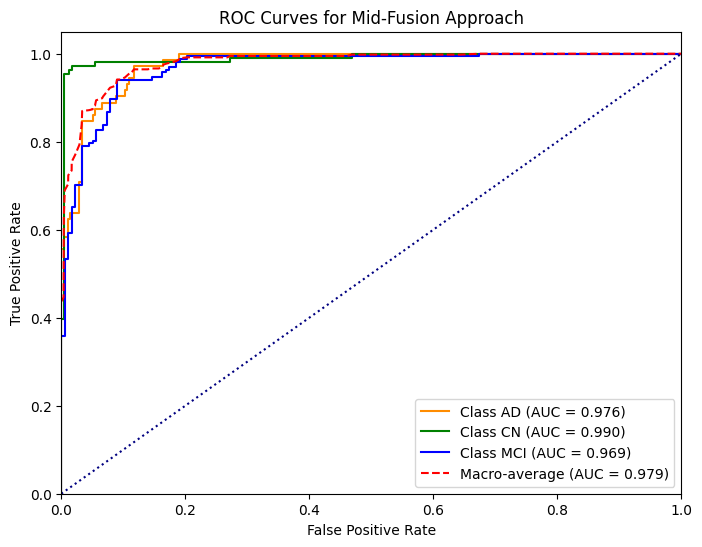

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# ... [Your existing imports and code remain the same] ...

# After you finish evaluating on the test set and have all_preds, all_labels:
# Instead of all_preds being only the predicted class, we also need predicted probabilities
# for multi-class ROC. So, we collect both.

model.eval()
total_test_correct = 0
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for deit_inputs, ft_inputs, labels in test_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)

        outputs = model(deit_inputs, ft_inputs)  # shape: (batch_size, num_classes)
        probs = torch.softmax(outputs, dim=1)     # convert logits to probabilities

        _, preds = torch.max(outputs, 1)

        total_test_correct += torch.sum(preds == labels.data)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_accuracy = total_test_correct.double() / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

# ------------------- ROC and AUC Calculation -------------------
# We have num_classes=3. We'll compute a one-vs-rest ROC for each class, plus a macro-average.

num_classes = len(label_encoder.classes_)

# Binarize the labels for each class: shape (num_samples, num_classes)
y_true = label_binarize(all_labels, classes=list(range(num_classes)))  # e.g., [0,1,2]

# Convert all_probs to a numpy array if not already
y_score = np.array(all_probs)  # shape: (num_samples, num_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC
# First aggregate all FPRs and TPRs
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
colors = ["darkorange", "green", "blue"]
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.3f})")

# Plot macro-average ROC
plt.plot(fpr["macro"], tpr["macro"], color="red", linestyle="--",
         label=f"Macro-average (AUC = {roc_auc['macro']:.3f})")

plt.plot([0, 1], [0, 1], color="navy", linestyle=":")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Mid-Fusion Approach")
plt.legend(loc="lower right")
plt.show()


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Check device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load DeiT features (expected shape: [num_samples, 768])
deit_train = np.load("Deit_train_features_1.npy")
deit_val   = np.load("Deit_val_features_1.npy")
deit_test  = np.load("Deit_test_features_1.npy")

# Load FTTransformer features (expected shape: [num_samples, 192])
ft_train = np.load("ft_train_embeddings.npy")
ft_val   = np.load("ft_val_embeddings.npy")
ft_test  = np.load("ft_test_embeddings.npy")

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

# Load CSV labels
train_data = pd.read_csv("train_data_3.csv")
val_data   = pd.read_csv("val_data_3.csv")
test_data  = pd.read_csv("test_data_3.csv")

label_col = "Group"
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

# Initialize scalers for each modality
scaler_deit = StandardScaler()
scaler_ft = StandardScaler()

# Fit scalers on training data and transform
train_features_deit = scaler_deit.fit_transform(deit_train)
val_features_deit = scaler_deit.transform(deit_val)
test_features_deit = scaler_deit.transform(deit_test)

train_features_ft = scaler_ft.fit_transform(ft_train)
val_features_ft = scaler_ft.transform(ft_val)
test_features_ft = scaler_ft.transform(ft_test)

# 4. Define the Concatenation Fusion Model
class ConcatenationFusionModel(nn.Module):
    def __init__(self, deit_input_size, ft_input_size, num_classes):
        super(ConcatenationFusionModel, self).__init__()
        # DeiT branch (image modality)
        self.deit_fc = nn.Sequential(
            nn.Linear(deit_input_size, 308),   # Dimensionality reduction from 768 to 384
            nn.BatchNorm1d(308),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # FTTransformer branch (tabular modality)
        self.ft_fc = nn.Sequential(
            nn.Linear(ft_input_size, 128),   # Dimensionality reduction from 192 to 128
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # Classifier: concatenated features from both branches (384+128=512)
        self.classifier = nn.Sequential(
            nn.Linear(436, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, deit_input, ft_input):
        # Process each modality separately
        deit_output = self.deit_fc(deit_input)    # (batch_size, 384)
        ft_output = self.ft_fc(ft_input)           # (batch_size, 128)
        # Concatenate features from both modalities
        concatenated_features = torch.cat([deit_output, ft_output], dim=1)  # (batch_size, 512)
        # Classify
        logits = self.classifier(concatenated_features)  # (batch_size, num_classes)
        return logits

# Initialize the model
image_input_size = train_features_deit.shape[1]  # 768
tab_input_size = train_features_ft.shape[1]        # 192

model = ConcatenationFusionModel(image_input_size, tab_input_size, num_classes)
model.to(device)


# 5. Prepare the data loaders
# Convert to tensors
train_deit_tensor = torch.tensor(train_features_deit, dtype=torch.float32)
val_deit_tensor = torch.tensor(val_features_deit, dtype=torch.float32)
test_deit_tensor = torch.tensor(test_features_deit, dtype=torch.float32)

train_ft_tensor = torch.tensor(train_features_ft, dtype=torch.float32)
val_ft_tensor = torch.tensor(val_features_ft, dtype=torch.float32)
test_ft_tensor = torch.tensor(test_features_ft, dtype=torch.float32)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(train_deit_tensor, train_ft_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_deit_tensor, val_ft_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_deit_tensor, test_ft_tensor, test_labels_tensor)

# Create data loaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 6. Training Setup
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early stopping parameters
early_stopping_patience = 10
epochs_no_improve = 0
best_val_loss = np.Inf

num_epochs = 100

# 7. Training Loop with Validation and Early Stopping mechanism
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    for deit_inputs, ft_inputs, labels in train_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(deit_inputs, ft_inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        total_train_correct += torch.sum(preds == labels.data)

    train_loss = total_train_loss / len(train_dataset)
    train_accuracy = total_train_correct.double() / len(train_dataset)

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    total_val_correct = 0
    with torch.no_grad():
        for deit_inputs, ft_inputs, labels in val_loader:
            deit_inputs = deit_inputs.to(device)
            ft_inputs = ft_inputs.to(device)
            labels = labels.to(device)

            outputs = model(deit_inputs, ft_inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            total_val_correct += torch.sum(preds == labels.data)

    val_loss = total_val_loss / len(val_dataset)
    val_accuracy = total_val_correct.double() / len(val_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping triggered.")
            break

# 8. Evaluate the Model on the Test Set
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
model.eval()
total_test_correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for deit_inputs, ft_inputs, labels in test_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        labels = labels.to(device)

        outputs = model(deit_inputs, ft_inputs)
        _, preds = torch.max(outputs, 1)

        total_test_correct += torch.sum(preds == labels.data)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = total_test_correct.double() / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Using device: cuda:1
DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Classes: ['AD' 'CN' 'MCI']


/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100] Train Loss: 1.0254, Train Acc: 0.4729 Val Loss: 0.9001, Val Acc: 0.7587
Best model saved.
Epoch [2/100] Train Loss: 0.8606, Train Acc: 0.6617 Val Loss: 0.7841, Val Acc: 0.8430
Best model saved.
Epoch [3/100] Train Loss: 0.7354, Train Acc: 0.7751 Val Loss: 0.6766, Val Acc: 0.8517
Best model saved.
Epoch [4/100] Train Loss: 0.6467, Train Acc: 0.8224 Val Loss: 0.6163, Val Acc: 0.8488
Best model saved.
Epoch [5/100] Train Loss: 0.5909, Train Acc: 0.8293 Val Loss: 0.5412, Val Acc: 0.8576
Best model saved.
Epoch [6/100] Train Loss: 0.5464, Train Acc: 0.8505 Val Loss: 0.4938, Val Acc: 0.8547
Best model saved.
Epoch [7/100] Train Loss: 0.4950, Train Acc: 0.8679 Val Loss: 0.4852, Val Acc: 0.8547
Best model saved.
Epoch [8/100] Train Loss: 0.4632, Train Acc: 0.8760 Val Loss: 0.4881, Val Acc: 0.8547
Epoch [9/100] Train Loss: 0.4428, Train Acc: 0.8766 Val Loss: 0.4319, Val Acc: 0.8517
Best model saved.
Epoch [10/100] Train Loss: 0.4066, Train Acc: 0.8810 Val Loss: 0.4142, Val Acc: 0.

/tmp/ipykernel_37572/265524843.py:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


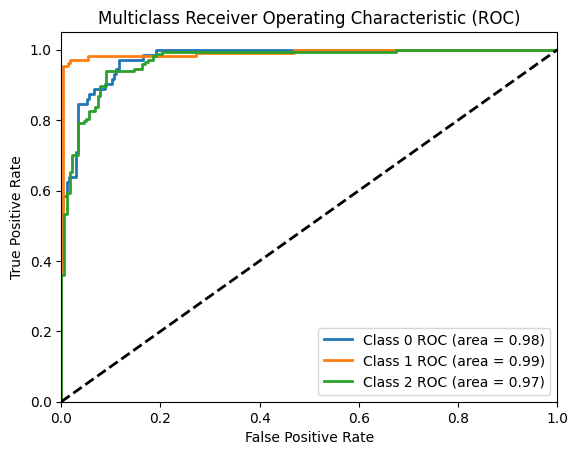

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# First, compute probabilities for the test set
all_probs = []
with torch.no_grad():
    for deit_inputs, ft_inputs, labels in test_loader:
        deit_inputs = deit_inputs.to(device)
        ft_inputs = ft_inputs.to(device)
        outputs = model(deit_inputs, ft_inputs)
        # Apply softmax to get probabilities
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
all_probs = np.concatenate(all_probs, axis=0)

# Convert true test labels to numpy array (already collected in all_labels earlier)
y_true = np.array(all_labels)

if num_classes == 2:
    # Binary classification: use probability of the positive class (assumed to be column 1)
    y_score = all_probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
else:
    # Multiclass classification: compute one-vs-rest ROC for each class.
    # Binarize the output labels
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curve for each class
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, 
                 label='Class {0} ROC (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


In [4]:
from sklearn.preprocessing import label_binarize

# Binarize the labels for one-vs-rest evaluation
y_true_bin = label_binarize(y_true, classes=range(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    auc_percentage = roc_auc[i] * 100
    print(f"Class {i} AUC: {roc_auc[i]:.4f} which is {auc_percentage:.2f}%")


Class 0 AUC: 0.9764 which is 97.64%
Class 1 AUC: 0.9899 which is 98.99%
Class 2 AUC: 0.9687 which is 96.87%


In [5]:
macro_auc = np.mean(list(roc_auc.values()))
print(f"Macro AUC: {macro_auc*100:.2f}%")


Macro AUC: 97.83%
